In [1]:
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score,precision_score, recall_score, f1_score, r2_score, mean_squared_error

from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestRegressor

In [2]:
import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

def formatar_moeda(valor):
    return locale.currency(valor, grouping=True)

Dados atualizados em 14/03/2024

In [3]:
tbl_dam = r'C:\Users\Acer\Projetos\Recife\dados\querys_modelos\tbl_dam_debito_14_03.csv'
tbl_historico_contribuinte = r'C:\Users\Acer\Projetos\Recife\dados\querys_modelos\tbl_historico_contribuinte_db_18_03.csv'

In [4]:
df_dam = pd.read_csv(tbl_dam, encoding='utf-8')
df_historico_contribuinte = pd.read_csv(tbl_historico_contribuinte, encoding='utf-8')

In [5]:
grandes_numeros = df_dam.groupby(['ano_fato_gerador']).agg({
    'vlr_aberto': 'sum',
    'vlr_pago': 'sum',
    'dam': 'nunique',
    'id_imovel': 'nunique',
    'id_contribuinte': 'nunique'
}).reset_index()

grandes_numeros['vlr_lancado'] = (grandes_numeros['vlr_aberto'] + grandes_numeros['vlr_pago']).apply(formatar_moeda)
grandes_numeros['vlr_aberto'] = grandes_numeros['vlr_aberto'].apply(formatar_moeda)
grandes_numeros['vlr_pago'] = grandes_numeros['vlr_pago'].apply(formatar_moeda)
grandes_numeros

,ano_fato_gerador,vlr_aberto,vlr_pago,dam,id_imovel,id_contribuinte,vlr_lancado
0,2017.0,"R$ 41.660.359,80","R$ 560.159.751,54",255559,254531,163895,"R$ 601.820.111,34"
1,2018.0,"R$ 51.386.768,99","R$ 539.554.695,70",240406,240246,157012,"R$ 590.941.464,69"
2,2019.0,"R$ 41.628.522,46","R$ 660.991.573,44",265954,265739,169578,"R$ 702.620.095,90"
3,2020.0,"R$ 57.085.317,40","R$ 668.308.373,95",261290,261227,167266,"R$ 725.393.691,35"
4,2021.0,"R$ 33.233.849,33","R$ 700.184.389,90",257194,257120,164480,"R$ 733.418.239,23"
5,2022.0,"R$ 290.607.003,56","R$ 812.636.539,06",359364,359266,215759,"R$ 1.103.243.542,62"
6,2023.0,"R$ 295.809.144,12","R$ 857.074.255,29",365201,365113,218236,"R$ 1.152.883.399,41"
7,2024.0,"R$ 1.100.096.806,67","R$ 42.041.864,23",366293,366292,219024,"R$ 1.142.138.670,90"


## MANIPULAÇÃO DE DADOS DA DÍVIDA

In [6]:
df_dam.head()

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_acessorio_dam,vlr_total_dam
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2021-01-26,1.0,39.0,2944.1,0.0,0.0,2944.1
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2019-01-08,1.0,39.0,2627.7,0.0,0.0,2627.7
2,000032f6d93a0abd,5c392b470f1f27a1295a294a15cb156f,71fc88ab6bbb201c344d77602867ec09,2024.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2024-01-01,0.0,39.0,0.0,1804.4,0.0,1804.4
3,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2022-01-21,1.0,39.0,3335.1,0.0,0.0,3335.1
4,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2023-01-23,1.0,39.0,3630.4,0.0,0.0,3630.4


In [7]:
contagem_imovel = df_dam.groupby('id_contribuinte')['id_imovel'].nunique()
registros_duplicados = df_dam[df_dam['id_contribuinte'].isin(contagem_imovel[contagem_imovel > 1].index)]
registros_duplicados.query('id_contribuinte == "4c375f5fe6f11e99cd124eb8021f7dca"')

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_acessorio_dam,vlr_total_dam
22,0000c599ab737fa1,35a5f340f67738f419002eec9f619408,4c375f5fe6f11e99cd124eb8021f7dca,2021.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2021-02-09,1.0,52.0,1112.60,0.00,0.00,1112.60
23,0000c599ab737fa1,491bd50714736f724c1f696350fff79e,4c375f5fe6f11e99cd124eb8021f7dca,2019.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2019-02-07,1.0,52.0,1055.40,0.00,0.00,1055.40
24,0000c599ab737fa1,52a09679bbf7a68690ecf5aaf6be6eb7,4c375f5fe6f11e99cd124eb8021f7dca,2023.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2023-12-19,0.0,52.0,0.00,1697.79,401.79,1697.79
25,0000c599ab737fa1,8360ed1065c0c9b611babe4a46e18b6d,4c375f5fe6f11e99cd124eb8021f7dca,2018.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2018-02-07,1.0,52.0,1014.70,0.00,0.00,1014.70
26,0000c599ab737fa1,8b7cc9eb1c4ce7c5e08920064611a7cf,4c375f5fe6f11e99cd124eb8021f7dca,2017.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2017-02-03,1.0,52.0,993.01,0.00,0.00,993.01
27,0000c599ab737fa1,bf7dabc23fbda539295a294a15cb156f,4c375f5fe6f11e99cd124eb8021f7dca,2024.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2024-01-01,0.0,52.0,0.00,1350.50,0.00,1350.50
28,0000c599ab737fa1,db7cb92fb806efc0875350beaddc7871,4c375f5fe6f11e99cd124eb8021f7dca,2022.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2022-01-31,1.0,52.0,1224.40,0.00,0.00,1224.40
29,0000c599ab737fa1,fbee00a70512c0e40ba9f03948490762,4c375f5fe6f11e99cd124eb8021f7dca,2020.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2020-02-07,1.0,52.0,1076.40,0.00,0.00,1076.40
402292,2b4e52aa40ed629d,56e1417b75d5110f295a294a15cb156f,4c375f5fe6f11e99cd124eb8021f7dca,2024.0,1,125.26,1,P,CASA,CONSTRUÍDA,ZUMBI,2008-12-11 19:06:14,2024-01-01,0.0,42.0,0.00,2865.40,0.00,2865.40
402293,2b4e52aa40ed629d,bb49f934732c9ea890ecf5aaf6be6eb7,4c375f5fe6f11e99cd124eb8021f7dca,2023.0,1,125.26,1,P,CASA,CONSTRUÍDA,ZUMBI,2008-12-11 19:06:14,2023-12-19,0.0,42.0,0.00,3591.50,850.30,3591.50


EURÍSTICA DE MANIPULAÇÃO DE DADOS ADOTADA
dam
ano_fato_gerador
id_imovel
idade_imovel 
vlr_aberto
vlr_pago
area_construida 
tipo_propriedade
bairro
natureza_imovel - tranforma p em 1 e t em 0
NOVA COLUNA chamada vlr_lançado = vlr_aberto + vlr_pago
NOVA COLUNA chamada aberto = se vlr_lançado = vlr_pago atribuir 1, se não atribuir 0

In [8]:
# dummizando a variavel de natureza de imóvel
mapeamento_natureza = {'P': 1, 'T': 0}
df_dam['natureza_imovel'] = df_dam['natureza_imovel'].map(mapeamento_natureza)

In [9]:
colunas_selecionadas = ['dam',  'id_imovel', 'id_contribuinte', 'ano_fato_gerador', 'natureza_imovel', 'idade_imovel', 'area_construida',
                      'tipo_propriedade', 'bairro', 'vlr_aberto', 'vlr_pago']

feature_dam = df_dam[colunas_selecionadas].copy()

feature_dam['vlr_lancado'] = feature_dam['vlr_aberto'] + feature_dam['vlr_pago']
feature_dam['aberto'] = (feature_dam['vlr_lancado'] != feature_dam['vlr_pago']).astype(int)
feature_dam

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,aberto
0,2d0abb2531f5995c19002eec9f619408,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2021.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2944.10,2944.10,0
1,393f868ac32df28f4c1f696350fff79e,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2019.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2627.70,2627.70,0
2,5c392b470f1f27a1295a294a15cb156f,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2024.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,1804.4,0.00,1804.40,1
3,7b9ddc3437bacdef875350beaddc7871,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2022.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,3335.10,3335.10,0
4,b114a952d31c024190ecf5aaf6be6eb7,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2023.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,3630.40,3630.40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2385006,c0ff37bd120cc0d619002eec9f619408,fffee3cacb174a68,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,42.0,89.15,APARTAMENTO,VARZEA,0.0,568.39,568.39,0
2385007,c8d60514c5f4b18ee08920064611a7cf,fffee3cacb174a68,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,42.0,89.15,APARTAMENTO,VARZEA,0.0,503.20,503.20,0
2385008,d97d28d5be81653f295a294a15cb156f,fffee3cacb174a68,76ab1d625a4a69d0d8b209292c0ce31d,2024.0,1,42.0,89.15,APARTAMENTO,VARZEA,692.0,0.00,692.00,1
2385009,e46ab0c52787357611babe4a46e18b6d,fffee3cacb174a68,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,42.0,89.15,APARTAMENTO,VARZEA,0.0,515.10,515.10,0


In [10]:
df_dam_nulos = feature_dam[feature_dam['bairro'].isnull()]
df_dam_nulos.head()

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,aberto
181022,28e87ba0e6079ed80ba9f03948490762,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2020.0,1,8.0,NaN,NaN,NaN,0.00,1260.20,1260.20,0
181023,4b65dd3735737b29e08920064611a7cf,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2017.0,1,8.0,NaN,NaN,NaN,1713.41,0.00,1713.41,1
181024,4f963eccb4677558295a294a15cb156f,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2024.0,1,8.0,NaN,NaN,NaN,1611.90,0.00,1611.90,1
181025,7fd0786f77af52324c1f696350fff79e,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2019.0,1,8.0,NaN,NaN,NaN,0.00,1240.02,1240.02,0
181026,9803a33efc9734c9875350beaddc7871,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2022.0,1,8.0,NaN,NaN,NaN,0.00,1447.40,1447.40,0


### TRATAMENTO DOS VALORES NULOS

In [11]:
valores_nulos_por_coluna = feature_dam.isnull().sum()
valores_nulos_por_coluna

# retirar os id_contribuinte nulos ou sem documento
# area_construida preencher com 0
# idade_imovel preencher com 0         
# tipo_propriedade preencher com 'TERRENO'  
# bairro preencher com 'DESCONHECIDO'

dam                      0
id_imovel                0
id_contribuinte     102224
ano_fato_gerador         0
natureza_imovel          0
idade_imovel         12144
area_construida      56961
tipo_propriedade     56961
bairro                  62
vlr_aberto               0
vlr_pago                 0
vlr_lancado              0
aberto                   0
dtype: int64

In [12]:
feature_dam = feature_dam.dropna(subset=['id_contribuinte']).copy()
feature_dam['area_construida'].fillna(0, inplace=True)
feature_dam['idade_imovel'].fillna(0, inplace=True)
feature_dam['tipo_propriedade'].fillna('TERRENO', inplace=True)
feature_dam['bairro'].fillna('DESCONHECIDO', inplace=True)


In [13]:
valores_nulos_por_coluna = feature_dam.isnull().sum()
valores_nulos_por_coluna

dam                 0
id_imovel           0
id_contribuinte     0
ano_fato_gerador    0
natureza_imovel     0
idade_imovel        0
area_construida     0
tipo_propriedade    0
bairro              0
vlr_aberto          0
vlr_pago            0
vlr_lancado         0
aberto              0
dtype: int64

In [14]:
feature_dam.head()

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,aberto
0,2d0abb2531f5995c19002eec9f619408,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2021.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2944.1,2944.1,0
1,393f868ac32df28f4c1f696350fff79e,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2019.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2627.7,2627.7,0
2,5c392b470f1f27a1295a294a15cb156f,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2024.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,1804.4,0.0,1804.4,1
3,7b9ddc3437bacdef875350beaddc7871,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2022.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,3335.1,3335.1,0
4,b114a952d31c024190ecf5aaf6be6eb7,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2023.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,3630.4,3630.4,0


## MANIPULAÇÃO DE DADOS DO CONTRIBUINTE

In [15]:
df_historico_contribuinte.columns

Index(['ano', 'id_contribuinte', 'tipo_pessoa', 'reco_debito',
       'reco_divida_ativa', 'freq_parcelamento', 'hist_pagamento_qtd',
       'num_imoveis', 'pgt_cota_unica', 'hist_aberto_qtd', 'hist_dams_totais',
       'hist_valor_aberto', 'hist_valor_pago', 'hist_valor_total'],
      dtype='object')

In [16]:
df_historico_contribuinte.query('ano == 2024')

,ano,id_contribuinte,tipo_pessoa,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica,hist_aberto_qtd,hist_dams_totais,hist_valor_aberto,hist_valor_pago,hist_valor_total
2776785,2024,00001a3e5b2177499daa7b7dbb545c1c,PF,0,0,0,0,1,0,0,0,0.0,0.0,0.0
2776786,2024,0000398c485f8b42344d77602867ec09,PF,0,0,0,0,1,0,1,1,986.4,0.0,986.4
2776787,2024,00003a695da4777aec557718ffae83ea,PF,0,0,0,0,1,0,1,1,1985.3,0.0,1985.3
2776788,2024,000046c85d18a6f7968646cfc1e328f2,PF,0,0,0,0,1,0,1,1,4192.3,0.0,4192.3
2776789,2024,0000b23be5378f1b8e79cf1867e8cc19,PF,0,0,0,0,4,0,1,1,1113.4,0.0,1113.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029215,2024,ffff0e3e56845cdf1603ecd7ff6be21f,PF,0,0,0,0,1,0,1,1,675.5,0.0,675.5
3029216,2024,ffff3836dbf935321bc34267b5521a39,PF,0,0,0,0,1,0,1,1,5700.2,0.0,5700.2
3029217,2024,ffff63826b501d84d8b209292c0ce31d,PF,0,0,0,0,2,0,1,1,2177.9,0.0,2177.9
3029218,2024,ffffc6563e67d8b38e79cf1867e8cc19,PF,0,0,0,0,3,0,1,1,1865.6,0.0,1865.6


EURÍSTICA ADOTADA PARA MANIPULAÇÃO DE DADOS

id_contribuinte
pgt_cota_unica
hist_pagamento
hist_valor_lançado
num_imoveis
reco_divida 
existe esta coluna reco_debito, eu calculei para esta coluna o valor contido em reco_debito + o valor contido em reco_divida sendo o total preenchido na coluna reco_debito
NOVA COLUNA reco_credito = a logica dessa coluna será a seguinte: será contar quantos id_contribuinte tem quando hist_valor_total for diferente de 0 em relação aos anos anteriores. exemplo: eu tenho na minha base o registo xxxx e eu tenho na base os anos entre 2013 e 2023 certo? quando for o registro de 2017 desse contribuinte xxxx eu vou realizar a logica olhando quantas vezes esse id_contribuinte apareceu até este ano em que o hist_valor_total foi diferente de 0 considerando tambem o ano atual, neste exemplo 2017 no caso, e assim cada ano eu terei a quantidade atualizada.

# Construção das variáveis de histórico e acumulativas ano a ano

In [17]:
feature_contribuinte = df_historico_contribuinte[['ano', 'id_contribuinte','reco_debito', 'pgt_cota_unica', 'hist_valor_pago', 'hist_valor_total', 'num_imoveis', 'reco_divida_ativa']].copy()
feature_contribuinte['hist_cota_unica'] = feature_contribuinte.groupby('id_contribuinte')['pgt_cota_unica'].cumsum()

# Construindo variavel historico de pagamento e valor lançado do contribuinte
feature_contribuinte['hist_pagamento'] = feature_contribuinte.groupby('id_contribuinte')['hist_valor_pago'].cumsum()
feature_contribuinte['hist_lancado'] = feature_contribuinte.groupby('id_contribuinte')['hist_valor_total'].cumsum()

# reco_debito
feature_contribuinte['reco_debito'] = feature_contribuinte['reco_debito'] + feature_contribuinte['reco_divida_ativa']

# reco_credito
feature_contribuinte['reco_credito'] = feature_contribuinte.groupby('id_contribuinte')['hist_valor_total'].apply(lambda x: (x.shift(1) != 0).cumsum())
feature_contribuinte['reco_credito'] = np.where(feature_contribuinte['hist_valor_total'] == 0, 0, feature_contribuinte['reco_credito'])

feature_contribuinte


,ano,id_contribuinte,reco_debito,pgt_cota_unica,hist_valor_pago,hist_valor_total,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito
0,2013,00001a3e5b2177499daa7b7dbb545c1c,0,0,0.0,0.0,1,0,0,0.00,0.00,0
1,2013,0000398c485f8b42344d77602867ec09,0,0,0.0,0.0,1,0,0,0.00,0.00,0
2,2013,00003a695da4777aec557718ffae83ea,0,0,0.0,0.0,1,0,0,0.00,0.00,0
3,2013,000046c85d18a6f7968646cfc1e328f2,0,0,0.0,0.0,1,0,0,0.00,0.00,0
4,2013,0000b23be5378f1b8e79cf1867e8cc19,0,0,0.0,0.0,4,0,0,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3029215,2024,ffff0e3e56845cdf1603ecd7ff6be21f,0,0,0.0,675.5,1,0,0,3276.63,4539.00,8
3029216,2024,ffff3836dbf935321bc34267b5521a39,0,0,0.0,5700.2,1,0,0,36270.98,41971.18,9
3029217,2024,ffff63826b501d84d8b209292c0ce31d,0,0,0.0,2177.9,2,0,0,13771.91,15949.81,9
3029218,2024,ffffc6563e67d8b38e79cf1867e8cc19,0,0,0.0,1865.6,3,0,1,10437.12,16737.86,8


In [18]:
feature_contribuinte.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,ano,id_contribuinte,reco_debito,pgt_cota_unica,hist_valor_pago,hist_valor_total,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito
44701,2013,2d6ae6e5dd1e57efae08d57f53945088,1,0,0.00,0.00,1,1,0,0.00,0.00,0
297136,2014,2d6ae6e5dd1e57efae08d57f53945088,1,0,0.00,0.00,1,1,0,0.00,0.00,0
549571,2015,2d6ae6e5dd1e57efae08d57f53945088,0,0,0.00,1482.67,1,0,0,0.00,1482.67,1
802006,2016,2d6ae6e5dd1e57efae08d57f53945088,1,0,0.00,0.00,1,1,0,0.00,1482.67,0
1054441,2017,2d6ae6e5dd1e57efae08d57f53945088,0,0,0.00,0.00,1,0,0,0.00,1482.67,0
1306876,2018,2d6ae6e5dd1e57efae08d57f53945088,0,1,1818.18,1818.18,1,0,1,1818.18,3300.85,2
1559311,2019,2d6ae6e5dd1e57efae08d57f53945088,0,1,1814.94,1814.94,1,0,2,3633.12,5115.79,3
1811746,2020,2d6ae6e5dd1e57efae08d57f53945088,0,1,1811.40,1811.40,1,0,3,5444.52,6927.19,4
2064181,2021,2d6ae6e5dd1e57efae08d57f53945088,0,1,1807.74,1807.74,1,0,4,7252.26,8734.93,5
2316616,2022,2d6ae6e5dd1e57efae08d57f53945088,0,1,1803.81,1803.81,1,0,5,9056.07,10538.74,6


## Variável percentual do Pagamento em cota única ano a ano 

In [19]:
# Criando a variável de percentual pago em cota única em cada ano por contribuinte
# Meu denominador que seria quantos créditos o contribuinte tem 
max_reco_credito = feature_contribuinte.groupby('id_contribuinte')['reco_credito'].max()

feature_contribuinte['acumulado_pgt_cota'] = feature_contribuinte.groupby('id_contribuinte')['pgt_cota_unica'].cumsum()

def calculate_percentual_pago_cota(row):
    id_contribuinte = row['id_contribuinte']
    return (row['acumulado_pgt_cota'] / max_reco_credito[id_contribuinte]) if id_contribuinte in max_reco_credito.index else np.nan

feature_contribuinte['percentual_pago_cota'] = feature_contribuinte.apply(calculate_percentual_pago_cota, axis=1)
feature_contribuinte = feature_contribuinte.drop(columns=['acumulado_pgt_cota'])

C:\Users\Acer\AppData\Local\Temp\ipykernel_12032\1393049071.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return (row['acumulado_pgt_cota'] / max_reco_credito[id_contribuinte]) if id_contribuinte in max_reco_credito.index else np.nan


## Variável percentual de Recorrência em débito ano a ano 

In [20]:
# Meu denominador que seria quantos créditos o contribuinte tem 
max_reco_credito = feature_contribuinte.groupby('id_contribuinte')['reco_credito'].max()

feature_contribuinte['acumulado_reco_debito'] = feature_contribuinte.groupby('id_contribuinte')['reco_debito'].cumsum()

def calculate_percentual_reco_debito(row):
    id_contribuinte = row['id_contribuinte']
    max_credito = max_reco_credito.get(id_contribuinte, 1)  # Evita divisão por zero
    acumulado_debito = row['acumulado_reco_debito']
    
    if max_credito == 0 or acumulado_debito == 0:
        return 0
    
    percentual = (acumulado_debito / max_credito) * 100
    return min(percentual, 100) / 100  # Trunco o valor

feature_contribuinte['percentual_reco_debito'] = feature_contribuinte.apply(calculate_percentual_reco_debito, axis=1)
feature_contribuinte = feature_contribuinte.drop(columns=['acumulado_reco_debito'])

In [21]:
feature_contribuinte.query('id_contribuinte == "00055311bbe1c1dd980abaecbf686355"')

,ano,id_contribuinte,reco_debito,pgt_cota_unica,hist_valor_pago,hist_valor_total,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito
16,2013,00055311bbe1c1dd980abaecbf686355,1,0,0.0,0.00,4,1,0,0.0,0.00,0,0.0,0.5
252451,2014,00055311bbe1c1dd980abaecbf686355,1,0,0.0,0.00,4,1,0,0.0,0.00,0,0.0,1.0
504886,2015,00055311bbe1c1dd980abaecbf686355,1,0,0.0,678.68,4,0,0,0.0,678.68,1,0.0,1.0
757321,2016,00055311bbe1c1dd980abaecbf686355,2,0,0.0,642.71,4,1,0,0.0,1321.39,2,0.0,1.0
1009756,2017,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,4,0,0,0.0,1321.39,0,0.0,1.0
1262191,2018,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,4,0,0,0.0,1321.39,0,0.0,1.0
1514626,2019,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,4,0,0,0.0,1321.39,0,0.0,1.0
1767061,2020,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,4,0,0,0.0,1321.39,0,0.0,1.0
2019496,2021,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,4,0,0,0.0,1321.39,0,0.0,1.0
2271931,2022,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,4,0,0,0.0,1321.39,0,0.0,1.0


## Variável percentual de Recorrência em dívida ativa ano a ano 

In [22]:
# Criando a variável de percentual de recorrência em dívida ativa para cada Ano

# Meu denominador que seria quantos créditos o contribuinte tem 
max_reco_debito = feature_contribuinte.groupby('id_contribuinte')['reco_debito'].sum()

feature_contribuinte['acumulado_reco_divida_ativa'] = feature_contribuinte.groupby('id_contribuinte')['reco_divida_ativa'].cumsum()

def calculate_percentual_pago_cota(row):
    id_contribuinte = row['id_contribuinte']
    return (row['acumulado_reco_divida_ativa'] / max_reco_debito[id_contribuinte]) if id_contribuinte in max_reco_debito.index else np.nan

feature_contribuinte['percentual_reco_divida_ativa'] = feature_contribuinte.apply(calculate_percentual_pago_cota, axis=1)
feature_contribuinte = feature_contribuinte.drop(columns=['acumulado_reco_divida_ativa'])

C:\Users\Acer\AppData\Local\Temp\ipykernel_12032\1834496839.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return (row['acumulado_reco_divida_ativa'] / max_reco_debito[id_contribuinte]) if id_contribuinte in max_reco_debito.index else np.nan


In [23]:
feature_contribuinte.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,ano,id_contribuinte,reco_debito,pgt_cota_unica,hist_valor_pago,hist_valor_total,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
44701,2013,2d6ae6e5dd1e57efae08d57f53945088,1,0,0.00,0.00,1,1,0,0.00,0.00,0,0.000,0.125,0.333333
297136,2014,2d6ae6e5dd1e57efae08d57f53945088,1,0,0.00,0.00,1,1,0,0.00,0.00,0,0.000,0.250,0.666667
549571,2015,2d6ae6e5dd1e57efae08d57f53945088,0,0,0.00,1482.67,1,0,0,0.00,1482.67,1,0.000,0.250,0.666667
802006,2016,2d6ae6e5dd1e57efae08d57f53945088,1,0,0.00,0.00,1,1,0,0.00,1482.67,0,0.000,0.375,1.000000
1054441,2017,2d6ae6e5dd1e57efae08d57f53945088,0,0,0.00,0.00,1,0,0,0.00,1482.67,0,0.000,0.375,1.000000
1306876,2018,2d6ae6e5dd1e57efae08d57f53945088,0,1,1818.18,1818.18,1,0,1,1818.18,3300.85,2,0.125,0.375,1.000000
1559311,2019,2d6ae6e5dd1e57efae08d57f53945088,0,1,1814.94,1814.94,1,0,2,3633.12,5115.79,3,0.250,0.375,1.000000
1811746,2020,2d6ae6e5dd1e57efae08d57f53945088,0,1,1811.40,1811.40,1,0,3,5444.52,6927.19,4,0.375,0.375,1.000000
2064181,2021,2d6ae6e5dd1e57efae08d57f53945088,0,1,1807.74,1807.74,1,0,4,7252.26,8734.93,5,0.500,0.375,1.000000
2316616,2022,2d6ae6e5dd1e57efae08d57f53945088,0,1,1803.81,1803.81,1,0,5,9056.07,10538.74,6,0.625,0.375,1.000000


In [24]:
feature_contribuinte = feature_contribuinte.drop(columns=['hist_valor_pago'])
feature_contribuinte = feature_contribuinte.drop(columns=['hist_valor_total'])

In [25]:
valores_nulos_por_coluna = feature_contribuinte.isnull().sum()
valores_nulos_por_coluna

ano                                   0
id_contribuinte                       0
reco_debito                           0
pgt_cota_unica                        0
num_imoveis                           0
reco_divida_ativa                     0
hist_cota_unica                       0
hist_pagamento                        0
hist_lancado                          0
reco_credito                          0
percentual_pago_cota             364308
percentual_reco_debito                0
percentual_reco_divida_ativa    1577952
dtype: int64

In [26]:
feature_contribuinte.query('percentual_reco_divida_ativa.isnull()')

,ano,id_contribuinte,reco_debito,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
0,2013,00001a3e5b2177499daa7b7dbb545c1c,0,0,1,0,0,0.00,0.00,0,NaN,0.0,NaN
2,2013,00003a695da4777aec557718ffae83ea,0,0,1,0,0,0.00,0.00,0,0.000,0.0,NaN
3,2013,000046c85d18a6f7968646cfc1e328f2,0,0,1,0,0,0.00,0.00,0,0.000,0.0,NaN
4,2013,0000b23be5378f1b8e79cf1867e8cc19,0,0,4,0,0,0.00,0.00,0,0.000,0.0,NaN
7,2013,00022915d03c589c0b59a1d5bcae3806,0,0,1,0,0,0.00,0.00,0,0.000,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029212,2024,fffea8c8c9cd46b4344d77602867ec09,0,0,1,0,0,0.00,0.00,0,NaN,0.0,NaN
3029216,2024,ffff3836dbf935321bc34267b5521a39,0,0,1,0,0,36270.98,41971.18,9,0.000,0.0,NaN
3029217,2024,ffff63826b501d84d8b209292c0ce31d,0,0,2,0,0,13771.91,15949.81,9,0.000,0.0,NaN
3029218,2024,ffffc6563e67d8b38e79cf1867e8cc19,0,0,3,0,1,10437.12,16737.86,8,0.125,0.0,NaN


In [27]:
# Os registros nulos são onde o contribuinte aparece na base mas, não tem nenhum lançamento e nenhum valor para o mesmo
feature_contribuinte['percentual_pago_cota'] = feature_contribuinte['percentual_pago_cota'].fillna(0)
feature_contribuinte['percentual_reco_divida_ativa'] = feature_contribuinte['percentual_reco_divida_ativa'].fillna(0)

# Equalizando o recorte de bases

### Após contruir as variáveis e comportamento do contribuinte desde 2013, realizo o recorte para a partir de 2017 para união com o recorte da base de DAM's

In [28]:
feature_contribuinte = feature_contribuinte.query('ano >= 2017')
feature_contribuinte

,ano,id_contribuinte,reco_debito,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
1009740,2017,00001a3e5b2177499daa7b7dbb545c1c,0,0,1,0,0,0.00,0.00,0,0.000,0.000,0.0
1009741,2017,0000398c485f8b42344d77602867ec09,0,0,1,0,0,721.31,721.31,1,0.000,0.000,0.0
1009742,2017,00003a695da4777aec557718ffae83ea,0,0,1,0,0,2762.91,2762.91,2,0.000,0.000,0.0
1009743,2017,000046c85d18a6f7968646cfc1e328f2,0,0,1,0,0,5636.90,5636.90,2,0.000,0.000,0.0
1009744,2017,0000b23be5378f1b8e79cf1867e8cc19,0,0,4,0,0,1508.04,3860.20,2,0.000,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029215,2024,ffff0e3e56845cdf1603ecd7ff6be21f,0,0,1,0,0,3276.63,4539.00,8,0.000,0.125,1.0
3029216,2024,ffff3836dbf935321bc34267b5521a39,0,0,1,0,0,36270.98,41971.18,9,0.000,0.000,0.0
3029217,2024,ffff63826b501d84d8b209292c0ce31d,0,0,2,0,0,13771.91,15949.81,9,0.000,0.000,0.0
3029218,2024,ffffc6563e67d8b38e79cf1867e8cc19,0,0,3,0,1,10437.12,16737.86,8,0.125,0.000,0.0


In [29]:
valores_nulos_por_coluna = feature_contribuinte.isnull().sum()
valores_nulos_por_coluna

ano                             0
id_contribuinte                 0
reco_debito                     0
pgt_cota_unica                  0
num_imoveis                     0
reco_divida_ativa               0
hist_cota_unica                 0
hist_pagamento                  0
hist_lancado                    0
reco_credito                    0
percentual_pago_cota            0
percentual_reco_debito          0
percentual_reco_divida_ativa    0
dtype: int64

In [30]:
valores_nulos_por_coluna = feature_dam.isnull().sum()
valores_nulos_por_coluna

dam                 0
id_imovel           0
id_contribuinte     0
ano_fato_gerador    0
natureza_imovel     0
idade_imovel        0
area_construida     0
tipo_propriedade    0
bairro              0
vlr_aberto          0
vlr_pago            0
vlr_lancado         0
aberto              0
dtype: int64

---

# UNIFICANDO BASE DE DAMS's COM A BASE DE INFORMAÇÃO DO CONTRIBUINTE

### EURÍSTICA ADOTADA

* Cada Dam reflete um ano em específico
* Os dados do contribuinte estão na mesma granularidade que a DAM

In [31]:
feature_dam.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,aberto
1728293,0242d546cc1bdeaa90ecf5aaf6be6eb7,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2023.0,1,18.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1799.62,1799.62,0
1728294,316b9bf26703ee59295a294a15cb156f,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2024.0,1,18.0,100.86,APARTAMENTO,BOA VIAGEM,1881.5,0.00,1881.50,1
1728295,5a442ba816b8eb3919002eec9f619408,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2021.0,1,18.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1807.74,1807.74,0
1728296,93330731628f4fea875350beaddc7871,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2022.0,1,18.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1803.81,1803.81,0
1728297,a51035cc3c80acf14c1f696350fff79e,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2019.0,1,18.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1814.94,1814.94,0
1728298,bfb0b6cb96105ef40ba9f03948490762,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2020.0,1,18.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1811.40,1811.40,0
1728299,d1460d862a9c557811babe4a46e18b6d,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2018.0,1,18.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1818.18,1818.18,0


In [32]:
feature_contribuinte.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,ano,id_contribuinte,reco_debito,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
1054441,2017,2d6ae6e5dd1e57efae08d57f53945088,0,0,1,0,0,0.00,1482.67,0,0.000,0.375,1.0
1306876,2018,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,1,1818.18,3300.85,2,0.125,0.375,1.0
1559311,2019,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,2,3633.12,5115.79,3,0.250,0.375,1.0
1811746,2020,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,3,5444.52,6927.19,4,0.375,0.375,1.0
2064181,2021,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,4,7252.26,8734.93,5,0.500,0.375,1.0
2316616,2022,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,5,9056.07,10538.74,6,0.625,0.375,1.0
2569051,2023,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,6,10855.69,12338.36,7,0.750,0.375,1.0
2821486,2024,2d6ae6e5dd1e57efae08d57f53945088,0,0,1,0,6,10855.69,14219.86,8,0.750,0.375,1.0


In [33]:
feature_store_credito = pd.merge(feature_dam, feature_contribuinte, 
                  left_on=['id_contribuinte', 'ano_fato_gerador'], 
                  right_on=['id_contribuinte', 'ano'], 
                  how='left')
feature_store_credito
feature_store_credito = feature_store_credito.sort_values(by=['id_contribuinte', 'ano'])
feature_store_credito

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,...,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
228276,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2017.0,1,56.0,110.15,CASA,AREIAS,0.00,...,0.0,1.0,0.0,0.0,721.31,721.31,1.0,0.0,0.0,0.0
228277,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2022.0,1,56.0,110.15,CASA,AREIAS,1379.50,...,0.0,1.0,1.0,0.0,721.31,2100.81,2.0,0.0,1.0,0.6
228275,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2023.0,1,56.0,110.15,CASA,AREIAS,1238.96,...,0.0,1.0,0.0,0.0,721.31,3339.77,3.0,0.0,1.0,0.6
228278,b218328f4c7ddb4d295a294a15cb156f,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2024.0,1,56.0,110.15,CASA,AREIAS,986.40,...,0.0,1.0,0.0,0.0,721.31,4326.17,4.0,0.0,1.0,0.6
961276,5aa15e7ff42aedb9e08920064611a7cf,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,2017.0,1,31.0,132.71,APARTAMENTO,AFLITOS,0.00,...,0.0,1.0,0.0,0.0,2762.91,2762.91,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313796,a5dbee1cfd0fe49c0ba9f03948490762,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2020.0,1,16.0,93.60,CASA,COHAB,0.00,...,0.0,1.0,0.0,0.0,5299.65,5299.65,6.0,0.0,0.0,0.0
313794,7ace6937886e01b219002eec9f619408,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2021.0,1,16.0,93.60,CASA,COHAB,0.00,...,0.0,1.0,0.0,0.0,5933.05,5933.05,7.0,0.0,0.0,0.0
313791,0b85676f02241e7a875350beaddc7871,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2022.0,1,16.0,93.60,CASA,COHAB,0.00,...,0.0,1.0,0.0,0.0,6635.33,6635.33,8.0,0.0,0.0,0.0
313792,0e5671b4abdff89490ecf5aaf6be6eb7,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2023.0,1,16.0,93.60,CASA,COHAB,0.00,...,0.0,1.0,0.0,0.0,7379.83,7379.83,9.0,0.0,0.0,0.0


In [34]:
feature_store_credito[['dam', 'id_imovel', 'id_contribuinte', 'ano_fato_gerador','vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'aberto', 'ano',]]

,dam,id_imovel,id_contribuinte,ano_fato_gerador,vlr_aberto,vlr_pago,vlr_lancado,aberto,ano
228276,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2017.0,0.00,721.31,721.31,0,2017.0
228277,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2022.0,1379.50,0.00,1379.50,1,2022.0
228275,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2023.0,1238.96,0.00,1238.96,1,2023.0
228278,b218328f4c7ddb4d295a294a15cb156f,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2024.0,986.40,0.00,986.40,1,2024.0
961276,5aa15e7ff42aedb9e08920064611a7cf,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,2017.0,0.00,1453.81,1453.81,0,2017.0
...,...,...,...,...,...,...,...,...,...
313796,a5dbee1cfd0fe49c0ba9f03948490762,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2020.0,0.00,621.13,621.13,0,2020.0
313794,7ace6937886e01b219002eec9f619408,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2021.0,0.00,633.40,633.40,0,2021.0
313791,0b85676f02241e7a875350beaddc7871,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2022.0,0.00,702.28,702.28,0,2022.0
313792,0e5671b4abdff89490ecf5aaf6be6eb7,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2023.0,0.00,744.50,744.50,0,2023.0


In [35]:
valores_nulos_por_coluna = feature_store_credito.isnull().sum()
valores_nulos_por_coluna

dam                                0
id_imovel                          0
id_contribuinte                    0
ano_fato_gerador                   0
natureza_imovel                    0
idade_imovel                       0
area_construida                    0
tipo_propriedade                   0
bairro                             0
vlr_aberto                         0
vlr_pago                           0
vlr_lancado                        0
aberto                             0
ano                             3265
reco_debito                     3265
pgt_cota_unica                  3265
num_imoveis                     3265
reco_divida_ativa               3265
hist_cota_unica                 3265
hist_pagamento                  3265
hist_lancado                    3265
reco_credito                    3265
percentual_pago_cota            3265
percentual_reco_debito          3265
percentual_reco_divida_ativa    3265
dtype: int64

In [36]:
feature_store_credito.query('ano.isnull()')

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,...,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
405178,0889a8607fed657a875350beaddc7871,2d84621c39fc3fb9,0057b1b274da35469daa7b7dbb545c1c,2022.0,1,41.0,71.47,APARTAMENTO,AREIAS,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
405179,2ed74940dfb729f80ba9f03948490762,2d84621c39fc3fb9,0057b1b274da35469daa7b7dbb545c1c,2020.0,1,41.0,71.47,APARTAMENTO,AREIAS,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
405180,371207b0af1e87cd4c1f696350fff79e,2d84621c39fc3fb9,0057b1b274da35469daa7b7dbb545c1c,2019.0,1,41.0,71.47,APARTAMENTO,AREIAS,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
405181,65b4d5958270b8bc295a294a15cb156f,2d84621c39fc3fb9,0057b1b274da35469daa7b7dbb545c1c,2024.0,1,41.0,71.47,APARTAMENTO,AREIAS,678.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
405182,74feeb4e4a5c67a190ecf5aaf6be6eb7,2d84621c39fc3fb9,0057b1b274da35469daa7b7dbb545c1c,2023.0,1,41.0,71.47,APARTAMENTO,AREIAS,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206580,81a2b1c0a14d326f19002eec9f619408,172ade54388274ac,ffc522c3bb63db60d8b209292c0ce31d,2021.0,1,12.0,86.29,APARTAMENTO,BARRO,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206581,937d2f51643c5a35e08920064611a7cf,172ade54388274ac,ffc522c3bb63db60d8b209292c0ce31d,2017.0,1,12.0,86.29,APARTAMENTO,BARRO,1187.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206582,b5b5259b66ce7d6f4c1f696350fff79e,172ade54388274ac,ffc522c3bb63db60d8b209292c0ce31d,2019.0,1,12.0,86.29,APARTAMENTO,BARRO,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206583,d346c74af20d3539295a294a15cb156f,172ade54388274ac,ffc522c3bb63db60d8b209292c0ce31d,2024.0,1,12.0,86.29,APARTAMENTO,BARRO,1400.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
feature_store_credito = feature_store_credito.dropna(subset=['ano'])

In [38]:
valores_nulos_por_coluna = feature_store_credito.isnull().sum()
valores_nulos_por_coluna

dam                             0
id_imovel                       0
id_contribuinte                 0
ano_fato_gerador                0
natureza_imovel                 0
idade_imovel                    0
area_construida                 0
tipo_propriedade                0
bairro                          0
vlr_aberto                      0
vlr_pago                        0
vlr_lancado                     0
aberto                          0
ano                             0
reco_debito                     0
pgt_cota_unica                  0
num_imoveis                     0
reco_divida_ativa               0
hist_cota_unica                 0
hist_pagamento                  0
hist_lancado                    0
reco_credito                    0
percentual_pago_cota            0
percentual_reco_debito          0
percentual_reco_divida_ativa    0
dtype: int64

In [39]:
feature_store_credito = feature_store_credito.drop(columns=['ano_fato_gerador'])

In [40]:
feature_store_credito.head(10)

,dam,id_imovel,id_contribuinte,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,...,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
228276,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,1,56.0,110.15,CASA,AREIAS,0.00,721.31,...,0.0,1.0,0.0,0.0,721.31,721.31,1.0,0.0,0.0,0.0
228277,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,1,56.0,110.15,CASA,AREIAS,1379.50,0.00,...,0.0,1.0,1.0,0.0,721.31,2100.81,2.0,0.0,1.0,0.6
228275,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,1,56.0,110.15,CASA,AREIAS,1238.96,0.00,...,0.0,1.0,0.0,0.0,721.31,3339.77,3.0,0.0,1.0,0.6
228278,b218328f4c7ddb4d295a294a15cb156f,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,1,56.0,110.15,CASA,AREIAS,986.40,0.00,...,0.0,1.0,0.0,0.0,721.31,4326.17,4.0,0.0,1.0,0.6
961276,5aa15e7ff42aedb9e08920064611a7cf,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,31.0,132.71,APARTAMENTO,AFLITOS,0.00,1453.81,...,0.0,1.0,0.0,0.0,2762.91,2762.91,2.0,0.0,0.0,0.0
961277,6d4837a02187b5d211babe4a46e18b6d,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,31.0,132.71,APARTAMENTO,AFLITOS,0.00,1486.60,...,0.0,1.0,0.0,0.0,4249.51,4249.51,3.0,0.0,0.0,0.0
961274,277b2982d51e63514c1f696350fff79e,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,31.0,132.71,APARTAMENTO,AFLITOS,0.00,1547.20,...,0.0,1.0,0.0,0.0,5796.71,5796.71,4.0,0.0,0.0,0.0
961272,0ef80ae81185fad10ba9f03948490762,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,31.0,132.71,APARTAMENTO,AFLITOS,0.00,1579.00,...,0.0,1.0,0.0,0.0,7375.71,7375.71,5.0,0.0,0.0,0.0
961279,e62adcde1ec2469e19002eec9f619408,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,31.0,132.71,APARTAMENTO,AFLITOS,0.00,1633.00,...,0.0,1.0,0.0,0.0,9008.71,9008.71,6.0,0.0,0.0,0.0
961273,12e432a8539cc69b875350beaddc7871,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,31.0,132.71,APARTAMENTO,AFLITOS,0.00,1798.10,...,0.0,1.0,0.0,0.0,10806.81,10806.81,7.0,0.0,0.0,0.0


consolidar

# IDENTIFICANDO OS TIPO DE DADOS DO MEU FEATURE STORE

In [41]:
feature_store_credito.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2279522 entries, 228276 to 313793
Data columns (total 24 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   dam                           object 
 1   id_imovel                     object 
 2   id_contribuinte               object 
 3   natureza_imovel               int64  
 4   idade_imovel                  float64
 5   area_construida               float64
 6   tipo_propriedade              object 
 7   bairro                        object 
 8   vlr_aberto                    float64
 9   vlr_pago                      float64
 10  vlr_lancado                   float64
 11  aberto                        int32  
 12  ano                           float64
 13  reco_debito                   float64
 14  pgt_cota_unica                float64
 15  num_imoveis                   float64
 16  reco_divida_ativa             float64
 17  hist_cota_unica               float64
 18  hist_pagamento    

In [42]:
feature_store_credito.select_dtypes(include='object').describe()

,dam,id_imovel,id_contribuinte,tipo_propriedade,bairro
count,2279522,2279522,2279522,2279522,2279522
unique,2266137,349065,220240,20,95
top,19829fbe189bd95be08920064611a7cf,f69b8da9f72594a1,878ed023fa473bede000edc2a2086273,APARTAMENTO,BOA VIAGEM
freq,3,15,7346,1347212,478500


In [43]:
feature_store_credito.query('dam == "19829fbe189bd95be08920064611a7cf"')

,dam,id_imovel,id_contribuinte,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,...,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
1830305,19829fbe189bd95be08920064611a7cf,cd8021faac24a9d5,b610c9e633c60c2e0246e2b93c1bf25c,1,23.0,76.58,APARTAMENTO,ARRUDA,0.00,24.84,...,0.0,1.0,0.0,0.0,744.09,1639.17,4.0,0.0,0.0,0.0
1830306,19829fbe189bd95be08920064611a7cf,cd8021faac24a9d5,b610c9e633c60c2e0246e2b93c1bf25c,1,23.0,76.58,APARTAMENTO,ARRUDA,689.91,0.00,...,0.0,1.0,0.0,0.0,744.09,1639.17,4.0,0.0,0.0,0.0
1830307,19829fbe189bd95be08920064611a7cf,cd8021faac24a9d5,b610c9e633c60c2e0246e2b93c1bf25c,1,23.0,76.58,APARTAMENTO,ARRUDA,0.00,59.84,...,0.0,1.0,0.0,0.0,744.09,1639.17,4.0,0.0,0.0,0.0


In [44]:
registros_duplicados = feature_store_credito[feature_store_credito.duplicated(subset=['dam'], keep=False)]
registros_duplicados

,dam,id_imovel,id_contribuinte,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,...,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
1941471,9c3d333e1bf37d49e08920064611a7cf,d9fbb381a72386eb,000775cf1100a512d8b209292c0ce31d,1,79.0,222.15,SALA,GRACAS,628.00,0.00,...,0.0,2.0,0.0,0.0,8765.92,11280.72,2.0,0.0,0.000000,0.0
1941472,9c3d333e1bf37d49e08920064611a7cf,d9fbb381a72386eb,000775cf1100a512d8b209292c0ce31d,1,79.0,222.15,SALA,GRACAS,0.00,5147.42,...,0.0,2.0,0.0,0.0,8765.92,11280.72,2.0,0.0,0.000000,0.0
1941467,1f5f4df3daa88f040ba9f03948490762,d9fbb381a72386eb,000775cf1100a512d8b209292c0ce31d,1,79.0,222.15,SALA,GRACAS,5488.07,0.00,...,0.0,2.0,1.0,0.0,20365.29,29395.66,5.0,0.0,0.222222,0.5
1941468,1f5f4df3daa88f040ba9f03948490762,d9fbb381a72386eb,000775cf1100a512d8b209292c0ce31d,1,79.0,222.15,SALA,GRACAS,0.00,1027.50,...,0.0,2.0,1.0,0.0,20365.29,29395.66,5.0,0.0,0.222222,0.5
2278680,fa2c72c6a080d4d619002eec9f619408,ff8e1a030a5d449e,00080ab2b7be2a799daa7b7dbb545c1c,1,42.0,172.03,CASA,TORROES,507.50,0.00,...,0.0,1.0,0.0,0.0,6540.23,7520.88,6.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305353,e496aa5490970ff7295a294a15cb156f,92548e666f12ee74,fff37d33d9b9afb27ff293197ac9de41,1,16.0,91.77,APARTAMENTO,MACAXEIRA,0.00,137.97,...,0.0,1.0,0.0,0.0,6962.64,8342.34,8.0,0.0,0.250000,0.5
1879507,5984204be8bcd29c11babe4a46e18b6d,d3161a941040bb3f,fff3d63f73d663138e79cf1867e8cc19,1,34.0,138.20,APARTAMENTO,BOA VIAGEM,662.17,0.00,...,0.0,4.0,0.0,0.0,6893.13,18245.64,3.0,0.0,0.000000,0.0
1879508,5984204be8bcd29c11babe4a46e18b6d,d3161a941040bb3f,fff3d63f73d663138e79cf1867e8cc19,1,34.0,138.20,APARTAMENTO,BOA VIAGEM,0.00,1263.22,...,0.0,4.0,0.0,0.0,6893.13,18245.64,3.0,0.0,0.000000,0.0
916710,c8ddc9fba0bccfcb4c1f696350fff79e,6688196900a4b6fd,fff3de3b7227e574be91dcec7d89e48e,1,32.0,109.50,APARTAMENTO,BOA VIAGEM,1534.41,0.00,...,0.0,1.0,0.0,0.0,4724.82,8023.01,5.0,0.0,0.000000,0.0


# CONSTRUINDO O FEATURE STORE FINAL PARA TREINAMENTO E PREDIÇÃO

* EXISTEM DAMS'S DUPLICADAS COM VALORES DIFERENTES, SERÃO AGRUPADAS PRESERVANDO A CARACTERÍSTICA DE CADA UMA DELAS

In [45]:
# Agrupando para exluir o fato de uma mesma dam ter mais de um registro
feature_store_credito = feature_store_credito.groupby(['id_contribuinte', 'dam', 'id_imovel', 'ano']).agg({
    'idade_imovel': 'first',
    'area_construida': 'first',
    'natureza_imovel': 'first',
    'tipo_propriedade': 'first',
    'bairro': 'first',
    'aberto': 'first',
    'num_imoveis': 'first',
    'vlr_aberto': 'sum',
    'vlr_pago': 'sum',
    'vlr_lancado': 'sum',
    'pgt_cota_unica': 'first',
    'hist_cota_unica': 'first',
    'hist_pagamento': 'first',
    'hist_lancado': 'first',
    'reco_debito': 'first',
    'reco_credito': 'first',
    'reco_divida_ativa': 'first',
    'percentual_pago_cota': 'first',
    'percentual_reco_debito': 'first',
    'percentual_reco_divida_ativa': 'first'
}).reset_index()

feature_store_credito

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,pgt_cota_unica,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,2023.0,56.0,110.15,1,CASA,AREIAS,1,...,0.0,0.0,721.31,3339.77,1.0,3.0,0.0,0.0,1.0,0.6
1,0000398c485f8b42344d77602867ec09,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,2017.0,56.0,110.15,1,CASA,AREIAS,0,...,0.0,0.0,721.31,721.31,0.0,1.0,0.0,0.0,0.0,0.0
2,0000398c485f8b42344d77602867ec09,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,2022.0,56.0,110.15,1,CASA,AREIAS,1,...,0.0,0.0,721.31,2100.81,2.0,2.0,1.0,0.0,1.0,0.6
3,0000398c485f8b42344d77602867ec09,b218328f4c7ddb4d295a294a15cb156f,1994cbd65b937ade,2024.0,56.0,110.15,1,CASA,AREIAS,1,...,0.0,0.0,721.31,4326.17,0.0,4.0,0.0,0.0,1.0,0.6
4,00003a695da4777aec557718ffae83ea,0ef80ae81185fad10ba9f03948490762,6b7e2fa2f4f1a593,2020.0,31.0,132.71,1,APARTAMENTO,AFLITOS,0,...,0.0,0.0,7375.71,7375.71,0.0,5.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266132,ffffe7d2325d80e6d8b209292c0ce31d,7ace6937886e01b219002eec9f619408,233f75a5f20edef9,2021.0,16.0,93.60,1,CASA,COHAB,0,...,0.0,0.0,5933.05,5933.05,0.0,7.0,0.0,0.0,0.0,0.0
2266133,ffffe7d2325d80e6d8b209292c0ce31d,807e85a93b8584ca11babe4a46e18b6d,233f75a5f20edef9,2018.0,16.0,93.60,1,CASA,COHAB,0,...,0.0,0.0,4082.82,4082.82,0.0,4.0,0.0,0.0,0.0,0.0
2266134,ffffe7d2325d80e6d8b209292c0ce31d,a5dbee1cfd0fe49c0ba9f03948490762,233f75a5f20edef9,2020.0,16.0,93.60,1,CASA,COHAB,0,...,0.0,0.0,5299.65,5299.65,0.0,6.0,0.0,0.0,0.0,0.0
2266135,ffffe7d2325d80e6d8b209292c0ce31d,d3d0e5512a43a626e08920064611a7cf,233f75a5f20edef9,2017.0,16.0,93.60,1,CASA,COHAB,0,...,0.0,0.0,3512.62,3512.62,0.0,3.0,0.0,0.0,0.0,0.0


In [46]:
feature_store_credito.select_dtypes(include='object').describe()

,id_contribuinte,dam,id_imovel,tipo_propriedade,bairro
count,2266137,2266137,2266137,2266137,2266137
unique,220240,2266137,349065,20,95
top,878ed023fa473bede000edc2a2086273,13fbc8d9654c9e3190ecf5aaf6be6eb7,1e1e2fb1d7c6cb5f,APARTAMENTO,BOA VIAGEM
freq,7323,1,14,1339072,475934


In [47]:
feature_store_credito['percentual_pago'] = (feature_store_credito['vlr_pago'] / feature_store_credito['vlr_lancado']).fillna(0)

In [48]:
feature_store_credito.columns

Index(['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel',
       'area_construida', 'natureza_imovel', 'tipo_propriedade', 'bairro',
       'aberto', 'num_imoveis', 'vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'pgt_cota_unica', 'hist_cota_unica', 'hist_pagamento', 'hist_lancado',
       'reco_debito', 'reco_credito', 'reco_divida_ativa',
       'percentual_pago_cota', 'percentual_reco_debito',
       'percentual_reco_divida_ativa', 'percentual_pago'],
      dtype='object')

# CORRELAÇÃO LINEAR

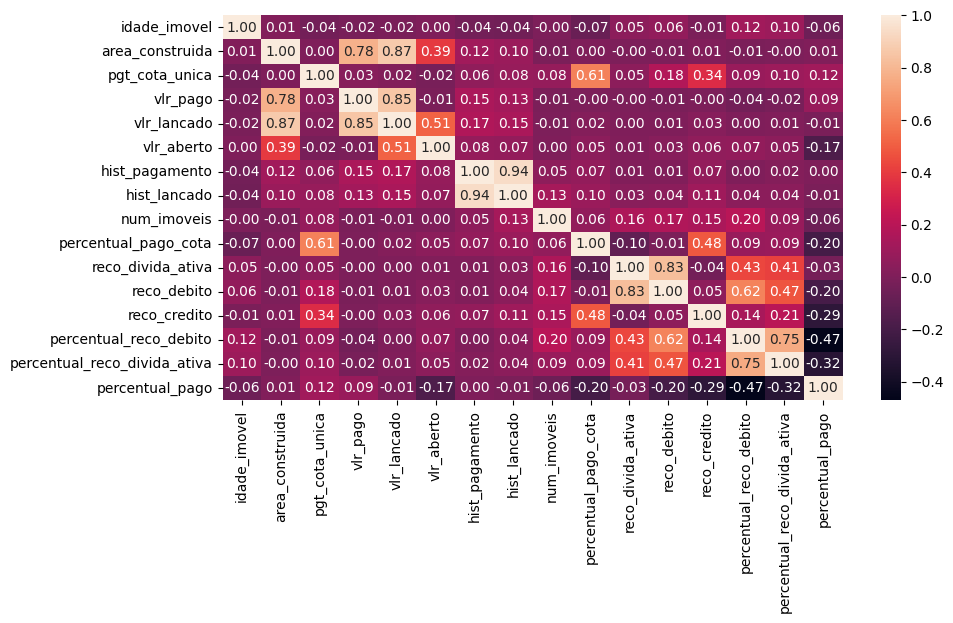

In [49]:
matriz_correlacao = feature_store_credito[['idade_imovel', 'area_construida',  'pgt_cota_unica',
                                    'vlr_pago', 'vlr_lancado', 'vlr_aberto', 'hist_pagamento', 
                                    'hist_lancado', 'num_imoveis', 'percentual_pago_cota',
                                    'reco_divida_ativa','reco_debito','reco_credito','percentual_reco_debito',
                                    'percentual_reco_divida_ativa', 'percentual_pago']].corr()
plt.figure(figsize=(10,5))
sns.heatmap(matriz_correlacao, annot = True, fmt = ".2f")
plt.show()

# CORRELAÇÃO NÃO LINEAR

In [50]:
from scipy.stats import spearmanr

matriz_correlacao_rank = feature_store_credito[['idade_imovel', 'area_construida',  'pgt_cota_unica',
                                    'vlr_pago', 'vlr_lancado', 'vlr_aberto', 'hist_pagamento', 
                                    'hist_lancado', 'num_imoveis', 'percentual_pago_cota',
                                    'reco_divida_ativa','reco_debito','reco_credito','percentual_reco_debito',
                                    'percentual_reco_divida_ativa', 'percentual_pago']].corr(method='spearman')
matriz_correlacao_rank

,idade_imovel,area_construida,pgt_cota_unica,vlr_pago,vlr_lancado,vlr_aberto,hist_pagamento,hist_lancado,num_imoveis,percentual_pago_cota,reco_divida_ativa,reco_debito,reco_credito,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago
idade_imovel,1.000000,-0.024195,-0.043476,-0.192750,-0.241081,0.041370,-0.189001,-0.170515,-0.076709,-0.065946,0.049005,0.066225,-0.011388,0.111155,0.104153,-0.059932
area_construida,-0.024195,1.000000,-0.042923,0.521347,0.806106,0.012926,0.337518,0.249318,-0.139384,-0.052019,-0.086359,-0.112441,-0.011729,-0.145051,-0.108975,0.061631
pgt_cota_unica,-0.043476,-0.042923,1.000000,0.123316,0.028241,-0.120847,0.251837,0.244363,0.193996,0.708030,0.049626,0.143350,0.352303,0.072753,0.090569,0.118861
vlr_pago,-0.192750,0.521347,0.123316,1.000000,0.549719,-0.700978,0.383125,0.240109,0.013082,-0.118966,-0.052898,-0.141450,-0.143246,-0.350285,-0.251820,0.726403
vlr_lancado,-0.241081,0.806106,0.028241,0.549719,1.000000,0.138142,0.534943,0.478639,0.023445,0.053571,-0.047478,-0.039795,0.119320,-0.059686,-0.035119,-0.050073
vlr_aberto,0.041370,0.012926,-0.120847,-0.700978,0.138142,1.000000,-0.025314,0.096033,0.006708,0.187036,0.030230,0.178365,0.277161,0.418590,0.303844,-0.982654
hist_pagamento,-0.189001,0.337518,0.251837,0.383125,0.534943,-0.025314,1.000000,0.911009,0.542791,0.325432,0.048381,0.030138,0.581049,0.012734,0.046966,0.062005
hist_lancado,-0.170515,0.249318,0.244363,0.240109,0.478639,0.096033,0.911009,1.000000,0.727133,0.317269,0.151423,0.162594,0.571933,0.196177,0.187840,-0.059849
num_imoveis,-0.076709,-0.139384,0.193996,0.013082,0.023445,0.006708,0.542791,0.727133,1.000000,0.220387,0.313793,0.313210,0.308053,0.326420,0.284025,-0.010468
percentual_pago_cota,-0.065946,-0.052019,0.708030,-0.118966,0.053571,0.187036,0.325432,0.317269,0.220387,1.000000,-0.076447,0.000615,0.542584,0.091874,0.104997,-0.195810


---

## INCLUINDO A NATUREZA JURÍDICA OU FÍSICA DO CONTRIBUINTE

In [51]:
arq_natureza = r'C:\Users\Acer\Projetos\Recife\dados\querys_modelos\RELACAO_IMOVEL_TIPO_CONTRIBUINTE.xlsx'
tbl_pf_pj = pd.read_excel(arq_natureza)
tbl_pf_pj 

,id_imovel,tipo_contribuinte
0,6b3a8e268c80aedf,PF
1,200d024ed1d1cc90,PJ
2,730b78533133f903,PJ
3,408002743410a58c,PJ
4,b7e964d611a3baa8,PF
...,...,...
517851,42e13a28e98c6be0,PF
517852,4b1a9413a179e1ea,PF
517853,6e3c9674c93ba1eb,PF
517854,b9e1dd322b5fbe3e,PF


In [52]:
tbl_pf_pj['tipo_contribuinte'] = tbl_pf_pj['tipo_contribuinte'].replace({'PF': 1, 'PJ': 0})
tbl_pf_pj

,id_imovel,tipo_contribuinte
0,6b3a8e268c80aedf,1
1,200d024ed1d1cc90,0
2,730b78533133f903,0
3,408002743410a58c,0
4,b7e964d611a3baa8,1
...,...,...
517851,42e13a28e98c6be0,1
517852,4b1a9413a179e1ea,1
517853,6e3c9674c93ba1eb,1
517854,b9e1dd322b5fbe3e,1


In [53]:
feature_store_credito = pd.merge(feature_store_credito, tbl_pf_pj, on='id_imovel', how='left')
feature_store_credito

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte
0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,2023.0,56.0,110.15,1,CASA,AREIAS,1,...,721.31,3339.77,1.0,3.0,0.0,0.0,1.0,0.6,0.0,1.0
1,0000398c485f8b42344d77602867ec09,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,2017.0,56.0,110.15,1,CASA,AREIAS,0,...,721.31,721.31,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0000398c485f8b42344d77602867ec09,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,2022.0,56.0,110.15,1,CASA,AREIAS,1,...,721.31,2100.81,2.0,2.0,1.0,0.0,1.0,0.6,0.0,1.0
3,0000398c485f8b42344d77602867ec09,b218328f4c7ddb4d295a294a15cb156f,1994cbd65b937ade,2024.0,56.0,110.15,1,CASA,AREIAS,1,...,721.31,4326.17,0.0,4.0,0.0,0.0,1.0,0.6,0.0,1.0
4,00003a695da4777aec557718ffae83ea,0ef80ae81185fad10ba9f03948490762,6b7e2fa2f4f1a593,2020.0,31.0,132.71,1,APARTAMENTO,AFLITOS,0,...,7375.71,7375.71,0.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266132,ffffe7d2325d80e6d8b209292c0ce31d,7ace6937886e01b219002eec9f619408,233f75a5f20edef9,2021.0,16.0,93.60,1,CASA,COHAB,0,...,5933.05,5933.05,0.0,7.0,0.0,0.0,0.0,0.0,1.0,1.0
2266133,ffffe7d2325d80e6d8b209292c0ce31d,807e85a93b8584ca11babe4a46e18b6d,233f75a5f20edef9,2018.0,16.0,93.60,1,CASA,COHAB,0,...,4082.82,4082.82,0.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0
2266134,ffffe7d2325d80e6d8b209292c0ce31d,a5dbee1cfd0fe49c0ba9f03948490762,233f75a5f20edef9,2020.0,16.0,93.60,1,CASA,COHAB,0,...,5299.65,5299.65,0.0,6.0,0.0,0.0,0.0,0.0,1.0,1.0
2266135,ffffe7d2325d80e6d8b209292c0ce31d,d3d0e5512a43a626e08920064611a7cf,233f75a5f20edef9,2017.0,16.0,93.60,1,CASA,COHAB,0,...,3512.62,3512.62,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0


## Acompanhamento da quantidade de registros em cada recorte

In [54]:
feature_store_credito_ate_21 = feature_store_credito.query('ano < 2022')
feature_store_credito_22 = feature_store_credito.query('ano == 2022')
feature_store_credito_23 = feature_store_credito.query('ano == 2023')
feature_store_credito_22_23 = feature_store_credito.query('ano > 2021')

In [55]:
ate_21 = feature_store_credito_ate_21.shape[0]
ano_22 = feature_store_credito_22.shape[0]
ano_23 = feature_store_credito_23.shape[0]
ano_22_23 = feature_store_credito_22_23.shape[0]
print(f'O número de registros em feature_store_credito_ate_22 é: {ate_21}')
print(f'O número de registros em feature_store_credito_ate_22 é: {ano_22}')
print(f'O número de registros em feature_store_credito_ate_22 é: {ano_23}')
print(f'O número de registros em feature_store_credito_ate_22 é: {ano_22_23}')

O número de registros em feature_store_credito_ate_22 é: 1239686
O número de registros em feature_store_credito_ate_22 é: 337821
O número de registros em feature_store_credito_ate_22 é: 343747
O número de registros em feature_store_credito_ate_22 é: 1026451


# PERFIL DA BASE

In [56]:
pagaram = feature_store_credito_ate_21.query('vlr_pago == vlr_lancado')
nao_pagaram = feature_store_credito_ate_21.query('vlr_pago == 0')
pagaram_parcialmente = feature_store_credito_ate_21.query('(vlr_pago > 0) & (vlr_pago < vlr_lancado)')

In [57]:
pagaram = pagaram.copy()
nao_pagaram = nao_pagaram.copy()
pagaram_parcialmente = pagaram_parcialmente.copy()

pagaram['contagem'] = 1
nao_pagaram['contagem'] = 1
pagaram_parcialmente['contagem'] = 1

contagem_pagaram_por_ano = pagaram.groupby('ano')['contagem'].count().reset_index()
contagem_nao_pagaram_por_ano = nao_pagaram.groupby('ano')['contagem'].count().reset_index()
contagem_pagaram_parcialmente_por_ano = pagaram_parcialmente.groupby('ano')['contagem'].count().reset_index()

contagem_pagaram_por_ano.columns = ['ano', 'pagaram']
contagem_nao_pagaram_por_ano.columns = ['ano', 'nao_pagaram']
contagem_pagaram_parcialmente_por_ano.columns = ['ano', 'pagaram_parcialmente']

perfil_base_ate_21_por_ano = pd.merge(contagem_pagaram_por_ano, contagem_nao_pagaram_por_ano, on='ano', how='outer')
perfil_base_ate_21_por_ano = pd.merge(perfil_base_ate_21_por_ano, contagem_pagaram_parcialmente_por_ano, on='ano', how='outer')

perfil_base_ate_21_por_ano = perfil_base_ate_21_por_ano.fillna(0)
perfil_base_ate_21_por_ano['total'] = perfil_base_ate_21_por_ano['pagaram'] + perfil_base_ate_21_por_ano['nao_pagaram'] + perfil_base_ate_21_por_ano['pagaram_parcialmente']

perfil_base_ate_21_por_ano

,ano,pagaram,nao_pagaram,pagaram_parcialmente,total
0,2017.0,232465,7432,6880,246777
1,2018.0,216557,9374,6349,232280
2,2019.0,244696,7162,5550,257408
3,2020.0,238012,7874,7494,253380
4,2021.0,240574,5035,4232,249841


In [58]:
totais_df_percentuais = perfil_base_ate_21_por_ano.copy()
totais_df_percentuais['pagaram'] = (totais_df_percentuais['pagaram'] / totais_df_percentuais['total']) * 100
totais_df_percentuais['nao_pagaram'] = (totais_df_percentuais['nao_pagaram'] / totais_df_percentuais['total']) * 100
totais_df_percentuais['pagaram_parcialmente'] = (totais_df_percentuais['pagaram_parcialmente'] / totais_df_percentuais['total']) * 100
totais_df_percentuais

,ano,pagaram,nao_pagaram,pagaram_parcialmente,total
0,2017.0,94.200432,3.011626,2.787942,246777
1,2018.0,93.231014,4.035647,2.733339,232280
2,2019.0,95.061537,2.782353,2.156110,257408
3,2020.0,93.934801,3.107585,2.957613,253380
4,2021.0,96.290841,2.015282,1.693877,249841


### Nos anos de 2017 a 2021 
* Adimplencia era em média de 94.54% 
* Inadimplência era em média de 2.98% 
* Pagantes parciais era em média de 2.46%

### Nos anos de 2022 a 2023 
* Adimplencia era em média de 71.58% 
* Inadimplência era em média de 22.87% 
* Pagantes parciais era em média de 5.53%

In [58]:
totais_df_percentuais['pagaram_parcialmente'].mean()

2.4662090680993147

## Filtrando dados para baseline

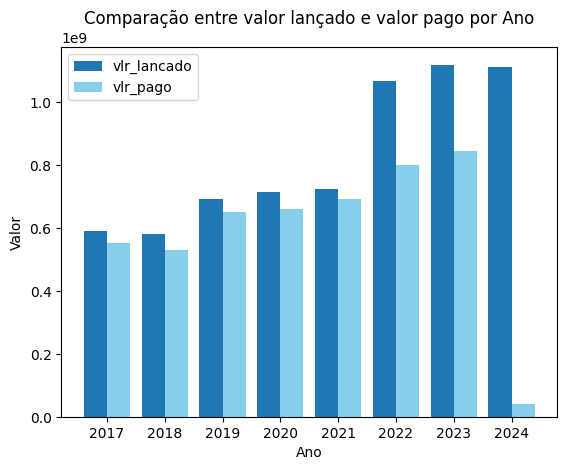

In [59]:
agrupado_por_ano = feature_store_credito.groupby('ano')[['vlr_lancado', 'vlr_pago']].sum().reset_index()

plt.bar(agrupado_por_ano['ano'] - 0.2, agrupado_por_ano['vlr_lancado'], width=0.4, label='vlr_lancado')
plt.bar(agrupado_por_ano['ano'] + 0.2, agrupado_por_ano['vlr_pago'], width=0.4, label='vlr_pago', color='skyblue')

plt.xlabel('Ano')
plt.ylabel('Valor')
plt.title('Comparação entre valor lançado e valor pago por Ano')
plt.legend()

plt.show()

In [60]:
somas_por_ano = feature_store_credito.groupby('ano')[['vlr_lancado', 'vlr_pago']].sum().reset_index()

somas_por_ano['inadimplência'] = somas_por_ano['vlr_lancado'] - somas_por_ano['vlr_pago']

somas_por_ano['vlr_lancado'] = somas_por_ano['vlr_lancado'].apply(formatar_moeda)
somas_por_ano['vlr_pago'] = somas_por_ano['vlr_pago'].apply(formatar_moeda)
somas_por_ano['inadimplência'] = somas_por_ano['inadimplência'].apply(formatar_moeda)

somas_por_ano

,ano,vlr_lancado,vlr_pago,inadimplência
0,2017.0,"R$ 591.506.863,17","R$ 550.776.798,10","R$ 40.730.065,07"
1,2018.0,"R$ 581.173.745,33","R$ 530.886.984,59","R$ 50.286.760,74"
2,2019.0,"R$ 692.011.843,65","R$ 651.278.832,27","R$ 40.733.011,38"
3,2020.0,"R$ 715.355.622,82","R$ 659.126.066,07","R$ 56.229.556,75"
4,2021.0,"R$ 723.782.859,16","R$ 690.969.506,93","R$ 32.813.352,23"
5,2022.0,"R$ 1.067.427.098,05","R$ 801.128.905,78","R$ 266.298.192,27"
6,2023.0,"R$ 1.118.775.506,79","R$ 845.184.569,84","R$ 273.590.936,95"
7,2024.0,"R$ 1.111.954.236,69","R$ 41.686.356,04","R$ 1.070.267.880,65"


In [140]:
# dezessete = contribuinte.query('ano == 2017')
df_dam.query('id_imovel == "d0e8a18b0409a8f2"')
# .query('id_contribuinte == "4c375f5fe6f11e99cd124eb8021f7dca"')

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_acessorio_dam,vlr_total_dam
1944436,d0e8a18b0409a8f2,5ef405b9ff47f198295a294a15cb156f,4c375f5fe6f11e99cd124eb8021f7dca,2024.0,1,125.0,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2024-01-01,0.0,52.0,0.00,1350.50,0.00,1350.50
1944437,d0e8a18b0409a8f2,75e230638b1ca7994c1f696350fff79e,4c375f5fe6f11e99cd124eb8021f7dca,2019.0,1,125.0,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2019-02-07,1.0,52.0,1055.40,0.00,0.00,1055.40
1944438,d0e8a18b0409a8f2,8968a410603ed0ae90ecf5aaf6be6eb7,4c375f5fe6f11e99cd124eb8021f7dca,2023.0,1,125.0,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2023-12-19,0.0,52.0,0.00,1697.79,401.79,1697.79
1944439,d0e8a18b0409a8f2,8983773358816aa111babe4a46e18b6d,4c375f5fe6f11e99cd124eb8021f7dca,2018.0,1,125.0,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2018-02-07,1.0,52.0,1014.70,0.00,0.00,1014.70
1944440,d0e8a18b0409a8f2,b0da6577445f2a3b875350beaddc7871,4c375f5fe6f11e99cd124eb8021f7dca,2022.0,1,125.0,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2022-01-31,1.0,52.0,1224.40,0.00,0.00,1224.40
1944441,d0e8a18b0409a8f2,cbf089fae63f78a0e08920064611a7cf,4c375f5fe6f11e99cd124eb8021f7dca,2017.0,1,125.0,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2017-02-10,1.0,52.0,993.01,0.00,0.00,993.01
1944442,d0e8a18b0409a8f2,d60e490f1564542119002eec9f619408,4c375f5fe6f11e99cd124eb8021f7dca,2021.0,1,125.0,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2021-02-09,1.0,52.0,1112.60,0.00,0.00,1112.60
1944443,d0e8a18b0409a8f2,e150ee8194d027c60ba9f03948490762,4c375f5fe6f11e99cd124eb8021f7dca,2020.0,1,125.0,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2020-02-07,1.0,52.0,1076.40,0.00,0.00,1076.40


### CONTEXTO DO IMÓVEL

In [61]:
contribuinte = feature_store_credito.groupby(['id_contribuinte','id_imovel', 'ano']).agg({
    'vlr_aberto': 'sum',
    'vlr_pago': 'sum',
    'vlr_lancado': 'sum',
    'vlr_aberto': 'sum',
    'pgt_cota_unica': 'first',
    'hist_cota_unica': 'first',
    'hist_pagamento': 'first',
    'hist_lancado': 'first',
    'reco_debito': 'first',
    'reco_credito': 'first',
    'reco_divida_ativa': 'first',
    'percentual_pago_cota': 'first',
    'percentual_reco_debito': 'first',
    'percentual_reco_divida_ativa': 'first',
    'percentual_pago': 'first'
}).reset_index()

Analisando comportamento dos imóveis que estão presentes em todos os anos

In [62]:
contribuintes_em_todos_os_anos = set(contribuinte.groupby('id_imovel')['ano'].nunique()[lambda x: x == len(contribuinte['ano'].unique())].index)
contribuinte_em_todos_os_anos = contribuinte[contribuinte['id_imovel'].isin(contribuintes_em_todos_os_anos)]
contribuinte_em_todos_os_anos

,id_contribuinte,id_imovel,ano,vlr_aberto,vlr_pago,vlr_lancado,pgt_cota_unica,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago
4,00003a695da4777aec557718ffae83ea,6b7e2fa2f4f1a593,2017.0,0.0,1453.81,1453.81,0.0,0.0,2762.91,2762.91,0.0,2.0,0.0,0.0,0.0,0.0,1.0
5,00003a695da4777aec557718ffae83ea,6b7e2fa2f4f1a593,2018.0,0.0,1486.60,1486.60,0.0,0.0,4249.51,4249.51,0.0,3.0,0.0,0.0,0.0,0.0,1.0
6,00003a695da4777aec557718ffae83ea,6b7e2fa2f4f1a593,2019.0,0.0,1547.20,1547.20,0.0,0.0,5796.71,5796.71,0.0,4.0,0.0,0.0,0.0,0.0,1.0
7,00003a695da4777aec557718ffae83ea,6b7e2fa2f4f1a593,2020.0,0.0,1579.00,1579.00,0.0,0.0,7375.71,7375.71,0.0,5.0,0.0,0.0,0.0,0.0,1.0
8,00003a695da4777aec557718ffae83ea,6b7e2fa2f4f1a593,2021.0,0.0,1633.00,1633.00,0.0,0.0,9008.71,9008.71,0.0,6.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2264409,ffffe7d2325d80e6d8b209292c0ce31d,233f75a5f20edef9,2020.0,0.0,621.13,621.13,0.0,0.0,5299.65,5299.65,0.0,6.0,0.0,0.0,0.0,0.0,1.0
2264410,ffffe7d2325d80e6d8b209292c0ce31d,233f75a5f20edef9,2021.0,0.0,633.40,633.40,0.0,0.0,5933.05,5933.05,0.0,7.0,0.0,0.0,0.0,0.0,1.0
2264411,ffffe7d2325d80e6d8b209292c0ce31d,233f75a5f20edef9,2022.0,0.0,702.28,702.28,0.0,0.0,6635.33,6635.33,0.0,8.0,0.0,0.0,0.0,0.0,1.0
2264412,ffffe7d2325d80e6d8b209292c0ce31d,233f75a5f20edef9,2023.0,0.0,744.50,744.50,0.0,0.0,7379.83,7379.83,0.0,9.0,0.0,0.0,0.0,0.0,1.0


In [63]:
analise_contribuinte = contribuinte_em_todos_os_anos.groupby('ano').agg({
    'id_imovel': 'nunique',
    'vlr_pago': 'sum',
    'vlr_lancado': 'sum'
}).reset_index()


analise_contribuinte['percentual_pago'] = (analise_contribuinte['vlr_pago'] / analise_contribuinte['vlr_lancado']) * 100

analise_contribuinte = analise_contribuinte.sort_values(by='ano')

# Aumento do valor lançado
analise_contribuinte['aumento_valor_lancado'] = analise_contribuinte['vlr_lancado'].diff()
analise_contribuinte['aumento_valor_lancado'].fillna(0, inplace=True)
analise_contribuinte['percentual_aumento_valor_lancado'] = (analise_contribuinte['vlr_lancado'].diff() / analise_contribuinte['vlr_lancado'].shift()) * 100
analise_contribuinte['percentual_aumento_valor_lancado'].fillna(0, inplace=True)
analise_contribuinte['percentual_aumento_valor_pago'] = (analise_contribuinte['vlr_pago'].diff() / analise_contribuinte['vlr_pago'].shift()) * 100
analise_contribuinte['percentual_aumento_valor_pago'].fillna(0, inplace=True)

analise_contribuinte.columns = ['ano', 'id_imovel', 'vlr_pago', 'vlr_lancado', 'percentual_pago', 'aumento_valor_lancado', 'percentual_aumento_valor_lancado', 'percentual_aumento_valor_pago']

analise_contribuinte['vlr_lancado'] = analise_contribuinte['vlr_lancado'].apply(formatar_moeda)
analise_contribuinte['aumento_valor_lancado'] = analise_contribuinte['aumento_valor_lancado'].apply(formatar_moeda)
analise_contribuinte['vlr_pago'] = analise_contribuinte['vlr_pago'].apply(formatar_moeda)
analise_contribuinte

,ano,id_imovel,vlr_pago,vlr_lancado,percentual_pago,aumento_valor_lancado,percentual_aumento_valor_lancado,percentual_aumento_valor_pago
0,2017.0,176899,"R$ 405.698.845,25","R$ 426.774.599,35",95.061619,"R$ 0,00",0.000000,0.000000
1,2018.0,176899,"R$ 433.713.402,75","R$ 451.753.294,99",96.006694,"R$ 24.978.695,64",5.852901,6.905259
2,2019.0,176899,"R$ 463.086.477,15","R$ 476.275.827,27",97.230733,"R$ 24.522.532,28",5.428302,6.772462
3,2020.0,176899,"R$ 471.169.474,83","R$ 493.148.793,45",95.543066,"R$ 16.872.966,18",3.542688,1.745462
4,2021.0,176899,"R$ 496.273.280,70","R$ 509.666.382,28",97.372183,"R$ 16.517.588,83",3.349413,5.327978
5,2022.0,176899,"R$ 544.495.408,02","R$ 563.585.049,76",96.612820,"R$ 53.918.667,48",10.579208,9.716849
6,2023.0,176899,"R$ 567.012.147,01","R$ 598.874.942,30",94.679558,"R$ 35.289.892,54",6.261680,4.135340
7,2024.0,176899,"R$ 30.274.947,43","R$ 617.079.239,66",4.906169,"R$ 18.204.297,36",3.039749,-94.660617


* Segundo prefeitura de Recife em 2022 obteve um aumento de 10,67% no valor do IPTU cobrado com o aumento do IPCA (Índice de preços ao consumidor amplo)
* Isso é refletido nos dados observando a evolução dos mesmos imóveis entre 2017 e 2023 no ano de 2022 de 10.64%

## Novos imóveis - A cada ano os imóveis que não aparecem nos anos anteriores

In [64]:
analise = pd.DataFrame(contribuinte)
contagem_total = []
contagem_novos = []

imoveis_unicos_globais = set()

for ano in range(2017, 2025):
    df_ano_atual = analise[analise['ano'] == ano]
    
    imoveis_unicos_ano_atual = set(df_ano_atual['id_imovel'])
    contagem_total.append(len(imoveis_unicos_ano_atual))

    imoveis_novos = imoveis_unicos_ano_atual - imoveis_unicos_globais
    contagem_novos.append(len(imoveis_novos))
    
    imoveis_unicos_globais.update(imoveis_unicos_ano_atual)

contagem_df = pd.DataFrame({'Ano': list(range(2017, 2025)),
                            'Total': contagem_total,
                            'Novos': contagem_novos})
contagem_df

,Ano,Total,Novos
0,2017,245752,245752
1,2018,232120,21297
2,2019,257194,12633
3,2020,253317,7185
4,2021,249767,5511
5,2022,337723,52548
6,2023,343659,3767
7,2024,344882,372


In [75]:
(21328+12650+7199+5520+52577) / 5

19854.8

### Verificação de imóveis novos em relação ao ano anterior

In [331]:
contra_prova = pd.DataFrame(contribuinte)

df_2021 = contra_prova[contra_prova['ano'] == 2018]
df_2022 = contra_prova[contra_prova['ano'] == 2019]
imoveis_unicos_2021 = set(df_2021['id_imovel'])
imoveis_unicos_2022 = set(df_2022['id_imovel'])

imoveis_novos_2022 = imoveis_unicos_2022 - imoveis_unicos_2021
quantidade_imoveis_novos_2022 = len(imoveis_novos_2022)

print(f"Quantidade de imóveis únicos em 2022 que não estavam presentes em 2021: {quantidade_imoveis_novos_2022}")

Quantidade de imóveis únicos em 2022 que não estavam presentes em 2021: 38477


### Descritivo dos registros que apareceram em 2022 e não apareceram nos anos anteriores

In [65]:
ano_interesse = 2022

id_imoveis_ano_interesse = set(feature_store_credito[feature_store_credito['ano'] == ano_interesse]['id_imovel'])
id_imoveis_anos_anteriores = set(feature_store_credito[feature_store_credito['ano'] < ano_interesse]['id_imovel'])

id_imoveis_novos_2022 = id_imoveis_ano_interesse - id_imoveis_anos_anteriores

registros_imoveis_novos_2022 = feature_store_credito[(feature_store_credito['ano'] == ano_interesse) & (feature_store_credito['id_imovel'].isin(id_imoveis_novos_2022))]
registros_imoveis_novos_2022

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte
144,000554c5705b8f31be91dcec7d89e48e,222265876522c289875350beaddc7871,5f537f5f4c7b5d64,2022.0,38.0,227.00,1,CASA,SANCHO,1,...,367.14,3198.45,2.0,3.0,1.0,0.000000,1.000000,0.818182,0.0,1.0
145,000554c5705b8f31be91dcec7d89e48e,3d2d5ea17fa2abb6875350beaddc7871,0fd2704b768f5ec1,2022.0,38.0,50.00,1,CASA,TEJIPIO,1,...,367.14,3198.45,2.0,3.0,1.0,0.000000,1.000000,0.818182,0.0,1.0
183,000627afce004bd2d4613fe022d53698,1a49f9493c4502c0875350beaddc7871,5c7d6bee95365501,2022.0,54.0,41.29,1,APARTAMENTO,BOA VISTA,1,...,0.00,427.44,2.0,1.0,1.0,0.000000,1.000000,0.750000,0.0,1.0
285,000a0685733c58fcd8b209292c0ce31d,a13b51bb2cc26ca5875350beaddc7871,d199dbe03307c331,2022.0,42.0,55.00,1,APARTAMENTO,MUSTARDINHA,1,...,0.00,386.27,2.0,1.0,1.0,0.000000,1.000000,0.818182,0.0,1.0
308,000af8d8be6de7c31db4804237c116dd,d8dcda5a0bcbf2db875350beaddc7871,9592dd651ab79d8b,2022.0,41.0,82.25,1,APARTAMENTO,AREIAS,0,...,1431.65,1431.65,1.0,2.0,1.0,0.000000,1.000000,0.800000,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2265857,fff5f3d945bfe3d076beb59f44c20df3,f5bec795df55fd24875350beaddc7871,ea575e456771ef38,2022.0,36.0,70.00,1,CASA,BONGI,1,...,3029.48,4040.22,2.0,6.0,1.0,0.000000,1.000000,0.818182,0.0,1.0
2265908,fff8aff6848c2d188e79cf1867e8cc19,e9059839361d3967875350beaddc7871,40f5c4dc59762a58,2022.0,32.0,54.50,1,APARTAMENTO,VARZEA,1,...,10328.36,17693.91,2.0,7.0,1.0,0.111111,1.000000,0.800000,0.0,1.0
2265920,fff9325728d059d81603ecd7ff6be21f,b23dba1130b282db875350beaddc7871,b3503af7cfe8182f,2022.0,41.0,71.47,1,APARTAMENTO,AREIAS,1,...,0.00,2160.17,2.0,3.0,1.0,0.000000,1.000000,0.714286,0.0,1.0
2265969,fffafcbc80a2ab2a1603ecd7ff6be21f,5cca6bf618589050875350beaddc7871,c79c2476626fa4b6,2022.0,34.0,60.00,1,CASA,BREJO DA GUABIRABA,1,...,35939.77,36986.44,2.0,7.0,1.0,0.000000,0.888889,0.777778,0.0,1.0


In [72]:
caminho = r'C:\Users\Acer\Projetos\Recife\dados\Novos_imoveis\imoveis_2022.xlsx'
registros_imoveis_novos_2022.to_excel(caminho, index=False)

In [81]:
# teste = contribuinte.query('ano == 2022')
teste = df_historico_contribuinte.query('id_contribuinte == "d39f4698d1f4fe9c2ce6574fb3ad1907"')
teste

,ano,id_contribuinte,tipo_pessoa,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica,hist_aberto_qtd,hist_dams_totais,hist_valor_aberto,hist_valor_pago,hist_valor_total
208463,2013,d39f4698d1f4fe9c2ce6574fb3ad1907,PF,0,0,0,0,1,0,0,0,0.0,0.00,0.00
460898,2014,d39f4698d1f4fe9c2ce6574fb3ad1907,PF,0,0,0,0,1,0,0,0,0.0,0.00,0.00
713333,2015,d39f4698d1f4fe9c2ce6574fb3ad1907,PF,0,0,0,0,1,0,0,0,0.0,0.00,0.00
965768,2016,d39f4698d1f4fe9c2ce6574fb3ad1907,PF,0,0,0,1,1,0,0,1,0.0,1227.50,1227.50
1218203,2017,d39f4698d1f4fe9c2ce6574fb3ad1907,PF,0,0,0,1,1,0,0,1,0.0,1371.61,1371.61
1470638,2018,d39f4698d1f4fe9c2ce6574fb3ad1907,PF,0,0,0,1,1,0,0,1,0.0,1411.80,1411.80
1723073,2019,d39f4698d1f4fe9c2ce6574fb3ad1907,PF,0,0,0,1,1,0,0,1,0.0,1656.90,1656.90
1975508,2020,d39f4698d1f4fe9c2ce6574fb3ad1907,PF,0,0,0,1,1,0,0,1,0.0,1697.90,1697.90
2227943,2021,d39f4698d1f4fe9c2ce6574fb3ad1907,PF,0,0,0,1,1,0,0,1,0.0,1763.00,1763.00
2480378,2022,d39f4698d1f4fe9c2ce6574fb3ad1907,PF,0,0,0,0,1,0,0,0,0.0,0.00,0.00


In [82]:
# formatar_moeda(registros_imoveis_novos_2022['vlr_aberto'].sum())
registros_imoveis_novos_2022['tipo_propriedade'].value_counts()

CASA                         21798
APARTAMENTO                  16550
TERRENO                       5679
SALA                          3505
LOJA                          2903
GALPÃO                         714
EDIFICAÇÃO ESPECIAL            584
GARAGEM COMERCIAL              404
MOCAMBO                        189
HOTEL                           67
INDUSTRIA                       65
INSTITUIÇÃO FINANCEIRA          23
INSTITUIÇÃO EDUCACIONAL         17
HOSPITAL                        16
CENTRO COMERCIAL/SERVIÇOS       13
TEMPLO RELIGIOSO                10
GALPÃO FECHADO                   9
POSTO DE ABASTECIMENTO           1
LOJA MÚLTIPLA                    1
Name: tipo_propriedade, dtype: int64

In [78]:
16567 / 52577 * 100

31.509975844951217

In [83]:
registros_imoveis_novos_2022.select_dtypes(include='object').describe()

,id_contribuinte,dam,id_imovel,tipo_propriedade,bairro
count,52548,52548,52548,52548,52548
unique,35475,52548,52548,19,94
top,878ed023fa473bede000edc2a2086273,222265876522c289875350beaddc7871,5f537f5f4c7b5d64,CASA,BOA VIAGEM
freq,909,1,1,21798,4181


In [84]:
individuo_devedor = registros_imoveis_novos_2022.query('id_contribuinte =="878ed023fa473bede000edc2a2086273"')
individuo_devedor

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte
1186176,878ed023fa473bede000edc2a2086273,0007800e7f730279875350beaddc7871,e41e0edbe3db3d28,2022.0,39.0,151.84,1,CASA,ENGENHO DO MEIO,1,...,58899.79,2282733.59,2.0,10.0,1.0,0.083333,1.0,0.5625,0.0,0.0
1186183,878ed023fa473bede000edc2a2086273,006aa2b2501876b5875350beaddc7871,05b5f6c7fe9b6d62,2022.0,21.0,64.05,1,APARTAMENTO,SANCHO,0,...,58899.79,2282733.59,2.0,10.0,1.0,0.083333,1.0,0.5625,1.0,0.0
1186189,878ed023fa473bede000edc2a2086273,00c4518a157926a8875350beaddc7871,dd59b6cabf35c493,2022.0,21.0,64.05,1,APARTAMENTO,SANCHO,1,...,58899.79,2282733.59,2.0,10.0,1.0,0.083333,1.0,0.5625,0.0,0.0
1186203,878ed023fa473bede000edc2a2086273,015def34d902f246875350beaddc7871,e96d62aa1f3e5867,2022.0,31.0,0.00,0,TERRENO,BREJO DA GUABIRABA,1,...,58899.79,2282733.59,2.0,10.0,1.0,0.083333,1.0,0.5625,0.0,0.0
1186221,878ed023fa473bede000edc2a2086273,01daaf0f87c3082d875350beaddc7871,0ce86f63a46a2d44,2022.0,52.0,149.44,1,CASA,JARDIM SAO PAULO,1,...,58899.79,2282733.59,2.0,10.0,1.0,0.083333,1.0,0.5625,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193455,878ed023fa473bede000edc2a2086273,fe6ca9eb82e66c7d875350beaddc7871,e48a0eb3a0703e1f,2022.0,41.0,0.00,0,TERRENO,COHAB,1,...,58899.79,2282733.59,2.0,10.0,1.0,0.083333,1.0,0.5625,0.0,0.0
1193457,878ed023fa473bede000edc2a2086273,fe7cdd4987651229875350beaddc7871,acb1be9566e665ae,2022.0,36.0,180.00,1,CASA,COHAB,1,...,58899.79,2282733.59,2.0,10.0,1.0,0.083333,1.0,0.5625,0.0,0.0
1193482,878ed023fa473bede000edc2a2086273,ff7f88a7deb7cc72875350beaddc7871,264ba5bc21db1d93,2022.0,42.0,650.00,1,APARTAMENTO,COHAB,1,...,58899.79,2282733.59,2.0,10.0,1.0,0.083333,1.0,0.5625,0.0,0.0
1193484,878ed023fa473bede000edc2a2086273,ff884d10f09c4dfc875350beaddc7871,a4b037ae38bd4e15,2022.0,41.0,0.00,0,TERRENO,COHAB,1,...,58899.79,2282733.59,2.0,10.0,1.0,0.083333,1.0,0.5625,0.0,0.0


In [443]:
formatar_moeda(individuo_devedor['vlr_lancado'].sum())

'R$ 1.566.325,78'

In [444]:
formatar_moeda(individuo_devedor['vlr_pago'].sum())

'R$ 13.562,73'

---

# INICIANDO CONSTRUÇÃO DO MODELO

# Seleção de variáveis

In [85]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

feature_store_credito['tipo_propriedade_encoded'] = le.fit_transform(feature_store_credito['tipo_propriedade'])

print("tipo_propriedade originais:", feature_store_credito['tipo_propriedade'].unique())
print("tipo_propriedade codificados:", feature_store_credito['tipo_propriedade_encoded'].unique())

tipo_propriedade originais: ['CASA' 'APARTAMENTO' 'SALA' 'LOJA' 'TERRENO' 'GARAGEM COMERCIAL'
 'EDIFICAÇÃO ESPECIAL' 'GALPÃO' 'MOCAMBO' 'INDUSTRIA'
 'INSTITUIÇÃO EDUCACIONAL' 'HOSPITAL' 'INSTITUIÇÃO FINANCEIRA'
 'CENTRO COMERCIAL/SERVIÇOS' 'HOTEL' 'GALPÃO FECHADO' 'TEMPLO RELIGIOSO'
 'POSTO DE ABASTECIMENTO' 'LOJA MÚLTIPLA' 'GARAGEM RESIDENCIAL']
tipo_propriedade codificados: [ 1  0 17 13 19  6  3  4 15 10 11  8 12  2  9  5 18 16 14  7]


In [86]:
feature_store_credito['perc_hist_pago'] = (feature_store_credito['hist_pagamento'] / feature_store_credito['hist_lancado']).fillna(0)

In [87]:
feature_store_credito.columns

Index(['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel',
       'area_construida', 'natureza_imovel', 'tipo_propriedade', 'bairro',
       'aberto', 'num_imoveis', 'vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'pgt_cota_unica', 'hist_cota_unica', 'hist_pagamento', 'hist_lancado',
       'reco_debito', 'reco_credito', 'reco_divida_ativa',
       'percentual_pago_cota', 'percentual_reco_debito',
       'percentual_reco_divida_ativa', 'percentual_pago', 'tipo_contribuinte',
       'tipo_propriedade_encoded', 'perc_hist_pago'],
      dtype='object')

In [88]:
feature_store_credito_ate_21 = feature_store_credito.query('ano < 2022')
feature_store_credito_22 = feature_store_credito.query('ano == 2022')
feature_store_credito_23 = feature_store_credito.query('ano == 2023')
feature_store_credito_22_23 = feature_store_credito.query('ano > 2021')

In [89]:
variaveis = ['idade_imovel', 'num_imoveis','natureza_imovel','reco_credito', 
             'perc_hist_pago','percentual_reco_debito','percentual_pago_cota',
             'reco_divida_ativa', 'percentual_reco_divida_ativa', 'tipo_contribuinte', 'percentual_pago',
             'tipo_propriedade_encoded']
variaveis_selecionadas = feature_store_credito_22[variaveis]
variaveis_selecionadas.columns

Index(['idade_imovel', 'num_imoveis', 'natureza_imovel', 'reco_credito',
       'perc_hist_pago', 'percentual_reco_debito', 'percentual_pago_cota',
       'reco_divida_ativa', 'percentual_reco_divida_ativa',
       'tipo_contribuinte', 'percentual_pago', 'tipo_propriedade_encoded'],
      dtype='object')

# São 479 registros de 77 contribuintes em que não há histórico para os mesmos

In [90]:
variaveis_selecionadas.isnull().sum()

idade_imovel                      0
num_imoveis                       0
natureza_imovel                   0
reco_credito                      0
perc_hist_pago                    0
percentual_reco_debito            0
percentual_pago_cota              0
reco_divida_ativa                 0
percentual_reco_divida_ativa      0
tipo_contribuinte               222
percentual_pago                   0
tipo_propriedade_encoded          0
dtype: int64

In [91]:
variaveis_selecionadas.query('tipo_contribuinte.isnull()')

,idade_imovel,num_imoveis,natureza_imovel,reco_credito,perc_hist_pago,percentual_reco_debito,percentual_pago_cota,reco_divida_ativa,percentual_reco_divida_ativa,tipo_contribuinte,percentual_pago,tipo_propriedade_encoded
10388,55.0,1.0,1,3.0,1.000000,0.800000,0.000000,1.0,1.000000,NaN,1.0,1
18916,26.0,5.0,1,10.0,0.463641,0.166667,0.083333,0.0,0.333333,NaN,1.0,13
23031,25.0,2.0,1,4.0,0.645296,0.666667,0.000000,1.0,0.600000,NaN,0.0,1
25591,28.0,1.0,1,8.0,1.000000,0.000000,0.000000,0.0,0.000000,NaN,1.0,17
26210,37.0,1.0,1,2.0,0.186658,1.000000,0.000000,1.0,0.818182,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2178933,23.0,1.0,1,7.0,1.000000,0.000000,0.000000,0.0,0.000000,NaN,1.0,0
2189446,15.0,1.0,1,7.0,1.000000,0.000000,0.111111,0.0,0.000000,NaN,1.0,0
2239953,41.0,1.0,0,1.0,0.000000,1.000000,0.000000,1.0,0.818182,NaN,0.0,19
2241987,38.0,1.0,1,2.0,0.143540,1.000000,0.000000,1.0,0.777778,NaN,0.0,0


In [92]:
variaveis_selecionadas = variaveis_selecionadas.dropna(subset=['tipo_contribuinte'])

In [93]:
variaveis_selecionadas.isnull().sum()

idade_imovel                    0
num_imoveis                     0
natureza_imovel                 0
reco_credito                    0
perc_hist_pago                  0
percentual_reco_debito          0
percentual_pago_cota            0
reco_divida_ativa               0
percentual_reco_divida_ativa    0
tipo_contribuinte               0
percentual_pago                 0
tipo_propriedade_encoded        0
dtype: int64

In [94]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

feature_store_credito['bairro_encoded'] = le.fit_transform(feature_store_credito['bairro'])

print("Bairros originais:", feature_store_credito['bairro'].unique())
print("Bairros codificados:", feature_store_credito['bairro_encoded'].unique())

Bairros originais: ['AREIAS ' 'AFLITOS ' 'BOA VIAGEM ' 'BOA VISTA ' 'CORDEIRO '
 'ALTO DO MANDU ' 'SAN MARTIN ' 'CASA AMARELA ' 'PARNAMIRIM ' 'GRACAS '
 'PINA ' 'JARDIM SAO PAULO ' 'TEJIPIO ' 'SANCHO ' 'ENGENHO DO MEIO '
 'ESPINHEIRO ' 'SANTANA ' 'TORROES ' 'ENCRUZILHADA ' 'AGUA FRIA '
 'HIPODROMO ' 'MUSTARDINHA ' 'BEBERIBE ' 'PRADO ' 'CAXANGA '
 'IMBIRIBEIRA ' 'TORRE ' 'FUNDAO ' 'IPSEP ' 'TAMARINEIRA ' 'JORDAO '
 'CAMPO GRANDE ' 'VARZEA ' 'DOIS UNIDOS ' 'MONTEIRO ' 'CACOTE '
 'MACAXEIRA ' 'POCO ' 'IPUTINGA ' 'IBURA ' 'SOLEDADE ' 'SANTO AMARO '
 'CASA FORTE ' 'LINHA DO TIRO ' 'COQUEIRAL ' 'CAMPINA DO BARRETO '
 'ROSARINHO ' 'AFOGADOS ' 'SANTO ANTONIO ' 'MADALENA ' 'BARRO ' 'ARRUDA '
 'JIQUIA ' 'MANGUEIRA ' 'ILHA DO LEITE ' 'CURADO ' 'GUABIRABA '
 'CAJUEIRO ' 'PONTO DE PARADA ' 'BREJO DA GUABIRABA ' 'VASCO DA GAMA '
 'SAO JOSE ' 'PORTO DA MADEIRA ' 'DERBY ' 'APIPUCOS ' 'JAQUEIRA ' 'COHAB '
 'BONGI ' 'BRASILIA TEIMOSA ' 'ILHA DO RETIRO ' 'TOTO ' 'CABANGA '
 'CORREGO DO JENIPAPO ' 'BREJO 

In [95]:
feature_store_credito_ate_21 = feature_store_credito.query('ano < 2021')
feature_store_credito_ate_22 = feature_store_credito.query('ano < 2023')
feature_store_credito_22 = feature_store_credito.query('ano == 2022')
feature_store_credito_23 = feature_store_credito.query('ano == 2023')
feature_store_credito_24 = feature_store_credito.query('ano == 2024')
feature_store_credito_22_23 = feature_store_credito.query('ano > 2021')

In [96]:
feature_store_credito_22.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,bairro_encoded
407543,2d6ae6e5dd1e57efae08d57f53945088,93330731628f4fea875350beaddc7871,b99a4cd3eca45812,2022.0,18.0,100.86,1,APARTAMENTO,BOA VIAGEM,0,...,6.0,0.0,0.625,0.375,1.0,1.0,1.0,0,0.859312,12


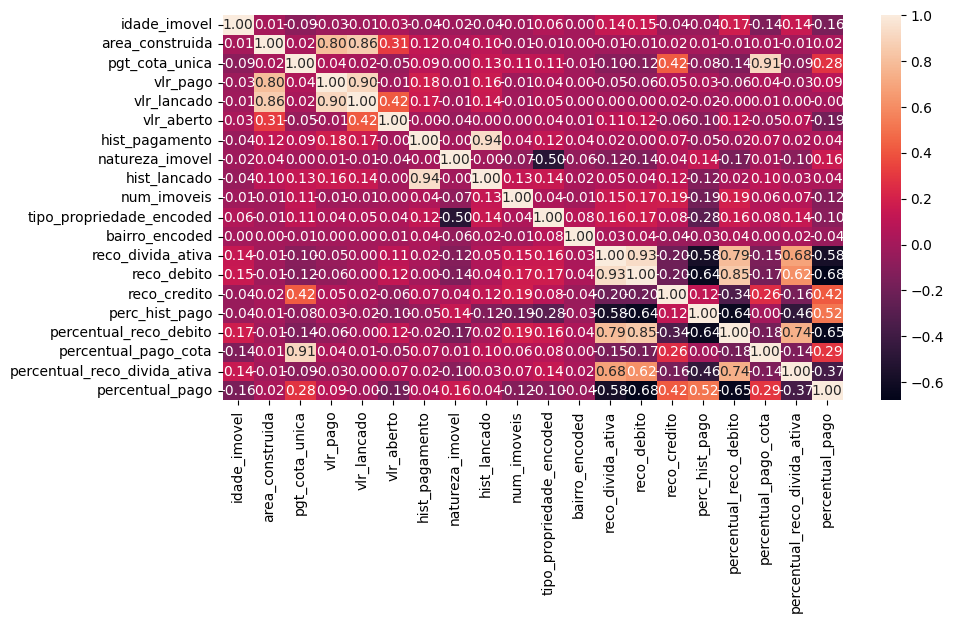

In [97]:
matriz_correlacao = feature_store_credito_22[['idade_imovel', 'area_construida',  'pgt_cota_unica',
                                    'vlr_pago', 'vlr_lancado', 'vlr_aberto', 'hist_pagamento', 'natureza_imovel',
                                    'hist_lancado', 'num_imoveis', 'tipo_propriedade_encoded', 'bairro_encoded',
                                    'reco_divida_ativa','reco_debito','reco_credito',
                                    'perc_hist_pago','percentual_reco_debito','percentual_pago_cota',
                                    'percentual_reco_divida_ativa', 'percentual_pago']].corr()
plt.figure(figsize=(10,5))
sns.heatmap(matriz_correlacao, annot = True, fmt = ".2f")
plt.show()

In [98]:
feature_store_credito_22 = feature_store_credito_22.dropna(subset=['tipo_contribuinte'])
feature_store_credito_22.isnull().sum()

id_contribuinte                 0
dam                             0
id_imovel                       0
ano                             0
idade_imovel                    0
area_construida                 0
natureza_imovel                 0
tipo_propriedade                0
bairro                          0
aberto                          0
num_imoveis                     0
vlr_aberto                      0
vlr_pago                        0
vlr_lancado                     0
pgt_cota_unica                  0
hist_cota_unica                 0
hist_pagamento                  0
hist_lancado                    0
reco_debito                     0
reco_credito                    0
reco_divida_ativa               0
percentual_pago_cota            0
percentual_reco_debito          0
percentual_reco_divida_ativa    0
percentual_pago                 0
tipo_contribuinte               0
tipo_propriedade_encoded        0
perc_hist_pago                  0
bairro_encoded                  0
dtype: int64

# REGRESSÃO LOGÍSTICA

In [99]:
feature_store_credito.columns

Index(['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel',
       'area_construida', 'natureza_imovel', 'tipo_propriedade', 'bairro',
       'aberto', 'num_imoveis', 'vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'pgt_cota_unica', 'hist_cota_unica', 'hist_pagamento', 'hist_lancado',
       'reco_debito', 'reco_credito', 'reco_divida_ativa',
       'percentual_pago_cota', 'percentual_reco_debito',
       'percentual_reco_divida_ativa', 'percentual_pago', 'tipo_contribuinte',
       'tipo_propriedade_encoded', 'perc_hist_pago', 'bairro_encoded'],
      dtype='object')

In [100]:
feature_store_credito_ate_22 = feature_store_credito.query('ano < 2023')
feature_store_credito_22 = feature_store_credito.query('ano == 2022')
feature_store_credito_23 = feature_store_credito.query('ano == 2023')
feature_store_credito_22_23 = feature_store_credito.query('ano > 2021')

In [101]:
feature_store_credito_22.shape[0]

337821

### Adicionando variável para regressão logística

In [102]:
feature_store_credito_22['pagamento'] = np.where(feature_store_credito_22['vlr_pago'] == feature_store_credito_22['vlr_lancado'], 1, 0)

C:\Users\Acer\AppData\Local\Temp\ipykernel_12032\1652875452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_store_credito_22['pagamento'] = np.where(feature_store_credito_22['vlr_pago'] == feature_store_credito_22['vlr_lancado'], 1, 0)


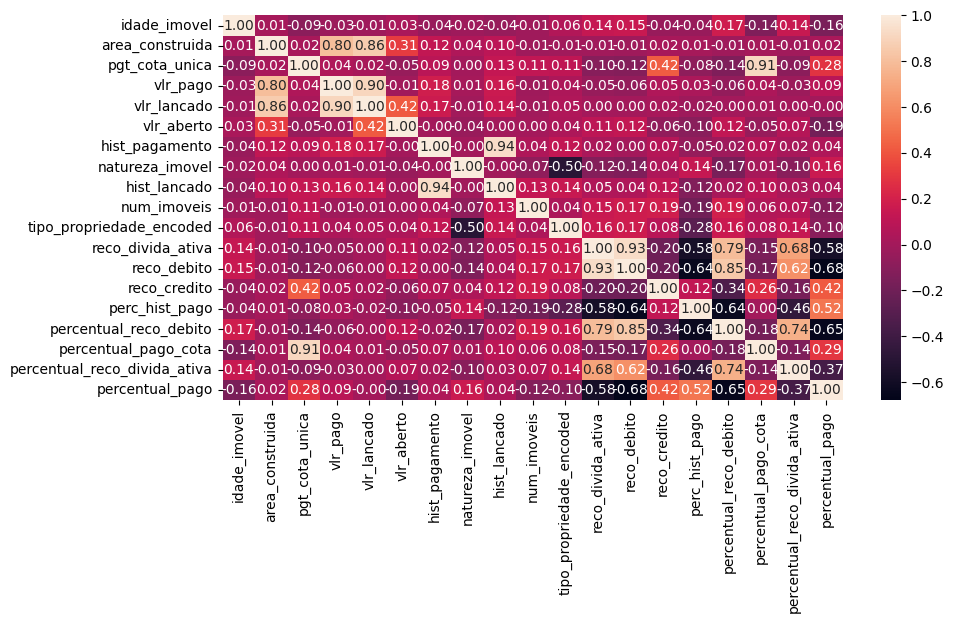

In [103]:
matriz_correlacao = feature_store_credito_22[['idade_imovel', 'area_construida',  'pgt_cota_unica',
                                    'vlr_pago', 'vlr_lancado', 'vlr_aberto', 'hist_pagamento', 'natureza_imovel',
                                    'hist_lancado', 'num_imoveis', 'tipo_propriedade_encoded',
                                    'reco_divida_ativa','reco_debito','reco_credito',
                                    'perc_hist_pago','percentual_reco_debito','percentual_pago_cota',
                                    'percentual_reco_divida_ativa', 'percentual_pago']].corr()
plt.figure(figsize=(10,5))
sns.heatmap(matriz_correlacao, annot = True, fmt = ".2f")
plt.show()

# Verificando o balancemento dos dados

In [104]:
total_registros = len(feature_store_credito_22)
contagem_por_label = feature_store_credito_22['pagamento'].value_counts()

porcentagem_por_label = (contagem_por_label / total_registros) * 100

resultados = pd.DataFrame({
    'Label': porcentagem_por_label.index,
    'Quantidade': contagem_por_label.values,
    'Porcentagem do Total': porcentagem_por_label.values
})
resultados

,Label,Quantidade,Porcentagem do Total
0,1,246350,72.923234
1,0,91471,27.076766


In [105]:
variaveis = ['idade_imovel', 'num_imoveis','natureza_imovel','reco_credito', 
             'perc_hist_pago','percentual_reco_debito','percentual_pago_cota',
             'reco_divida_ativa', 'percentual_reco_divida_ativa', 'pagamento',
             'tipo_propriedade_encoded']
variaveis_selecionadas = feature_store_credito_22[variaveis]
variaveis_selecionadas.columns

Index(['idade_imovel', 'num_imoveis', 'natureza_imovel', 'reco_credito',
       'perc_hist_pago', 'percentual_reco_debito', 'percentual_pago_cota',
       'reco_divida_ativa', 'percentual_reco_divida_ativa', 'pagamento',
       'tipo_propriedade_encoded'],
      dtype='object')

In [106]:
y = variaveis_selecionadas['pagamento']
x = variaveis_selecionadas.drop(columns=['pagamento'])

In [107]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.3)

In [221]:
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [108]:
normalizador = RobustScaler() #StandardScaler() #StandardScaler()
normalizador.fit(x)
dados_normalizados = normalizador.fit_transform(x)
colunas = list(normalizador.get_feature_names_out())
df_normalizado = pd.DataFrame(dados_normalizados, columns=colunas)

## REGRESSÃO LOGÍSTICA XGBOOST

In [109]:
xbg_logistico = XGBClassifier(objective="binary:logistic", random_state=42)
xbg_logistico.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [110]:
Predicao_probabilidade = xbg_logistico.predict_proba(X_test)[:, 1]

In [111]:
Predicao_0_ou_1 = xbg_logistico.predict(X_test)

In [112]:
conf_matrix = confusion_matrix(y_test, Predicao_0_ou_1)

df_conf_matrix = pd.DataFrame(conf_matrix, index=['Real Negativo', 'Real Positivo'], columns=['Predito Negativo', 'Predito Positivo'])
print("Matriz de Confusão:")
df_conf_matrix 

Matriz de Confusão:


,Predito Negativo,Predito Positivo
Real Negativo,22702,4732
Real Positivo,3322,70591


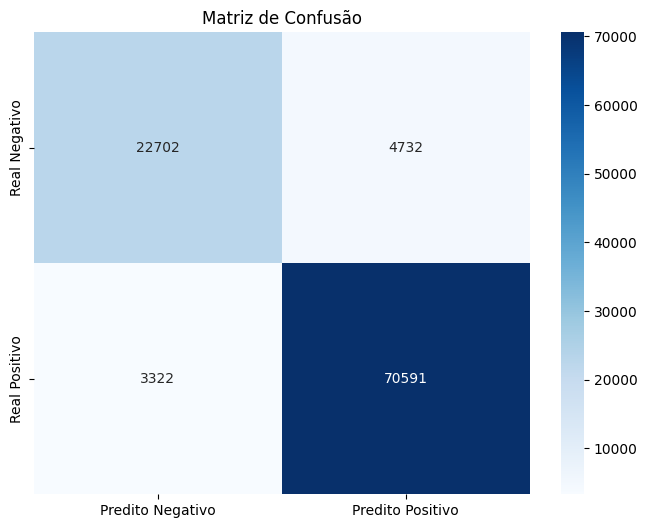

In [113]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

In [114]:
acuracia = accuracy_score(y_test, Predicao_0_ou_1)
roc_auc = roc_auc_score(y_test, Predicao_probabilidade)
precisao = precision_score(y_test, Predicao_0_ou_1)
revocacao = recall_score(y_test, Predicao_0_ou_1)
f1 = f1_score(y_test, Predicao_0_ou_1)
print(f"Accuracia: {acuracia}")
print(f"ROC AUC: {roc_auc}")
print(f"Precisão: {precisao}")
print(f"Revocação (Sensibilidade): {revocacao}")
print(f"F1 Score: {f1}")

Accuracia: 0.9205304547741916
ROC AUC: 0.9761923633589341
Precisão: 0.937177223424452
Revocação (Sensibilidade): 0.9550552676795693
F1 Score: 0.9460317885764828


---

## REGRESSÃO LOGÍSTICA

In [179]:
modelo_logistico = LogisticRegression()
modelo_logistico.fit(X_train, y_train)

c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [180]:
Predicao_probabilidade = modelo_logistico.predict_proba(X_test)[:, 1]

In [181]:
Predicao_0_ou_1 = modelo_logistico.predict(X_test)

In [182]:
conf_matrix = confusion_matrix(y_test, Predicao_0_ou_1)

df_conf_matrix = pd.DataFrame(conf_matrix, index=['Real Negativo', 'Real Positivo'], columns=['Predito Negativo', 'Predito Positivo'])
print("Matriz de Confusão:")
df_conf_matrix 

Matriz de Confusão:


,Predito Negativo,Predito Positivo
Real Negativo,17845,9589
Real Positivo,5159,68754


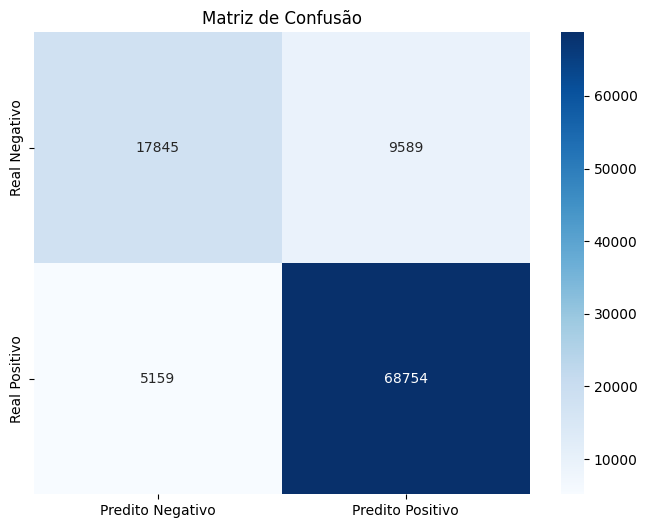

In [183]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

In [184]:
acuracia = accuracy_score(y_test, Predicao_0_ou_1)
roc_auc = roc_auc_score(y_test, Predicao_probabilidade)
precisao = precision_score(y_test, Predicao_0_ou_1)
revocacao = recall_score(y_test, Predicao_0_ou_1)
f1 = f1_score(y_test, Predicao_0_ou_1)
print(f"Accuracia: {acuracia}")
print(f"ROC AUC: {roc_auc}")
print(f"Precisão: {precisao}")
print(f"Revocação (Sensibilidade): {revocacao}")
print(f"F1 Score: {f1}")

Accuracia: 0.8544801523478741
ROC AUC: 0.9182406518749607
Precisão: 0.8776023384348315
Revocação (Sensibilidade): 0.9302017236480727
F1 Score: 0.9031368221941992


---

# PREDIÇÃO EM DADOS DE 2024

In [116]:
feature_store_credito_24.columns

Index(['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel',
       'area_construida', 'natureza_imovel', 'tipo_propriedade', 'bairro',
       'aberto', 'num_imoveis', 'vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'pgt_cota_unica', 'hist_cota_unica', 'hist_pagamento', 'hist_lancado',
       'reco_debito', 'reco_credito', 'reco_divida_ativa',
       'percentual_pago_cota', 'percentual_reco_debito',
       'percentual_reco_divida_ativa', 'percentual_pago', 'tipo_contribuinte',
       'tipo_propriedade_encoded', 'perc_hist_pago', 'bairro_encoded'],
      dtype='object')

In [117]:
df_feature_store_predict = feature_store_credito_24.copy()

In [118]:
df_feature_store_predict.isnull().sum()

id_contribuinte                   0
dam                               0
id_imovel                         0
ano                               0
idade_imovel                      0
area_construida                   0
natureza_imovel                   0
tipo_propriedade                  0
bairro                            0
aberto                            0
num_imoveis                       0
vlr_aberto                        0
vlr_pago                          0
vlr_lancado                       0
pgt_cota_unica                    0
hist_cota_unica                   0
hist_pagamento                    0
hist_lancado                      0
reco_debito                       0
reco_credito                      0
reco_divida_ativa                 0
percentual_pago_cota              0
percentual_reco_debito            0
percentual_reco_divida_ativa      0
percentual_pago                   0
tipo_contribuinte               227
tipo_propriedade_encoded          0
perc_hist_pago              

In [119]:
df_feature_store_predict.shape[0]

344883

# criando a variavel resposta

In [120]:
df_feature_store_predict['pagamento'] = np.where(df_feature_store_predict['vlr_pago'] == df_feature_store_predict['vlr_lancado'], 1, 0)

In [121]:
df_feature_store_predict.head()

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,bairro_encoded,pagamento
3,0000398c485f8b42344d77602867ec09,b218328f4c7ddb4d295a294a15cb156f,1994cbd65b937ade,2024.0,56.0,110.15,1,CASA,AREIAS,1,...,0.0,0.000000,1.0,0.6,0.0,1.0,1,0.166732,8,0
7,00003a695da4777aec557718ffae83ea,4a4c53a5f2f6ac79295a294a15cb156f,6b7e2fa2f4f1a593,2024.0,31.0,132.71,1,APARTAMENTO,AFLITOS,1,...,0.0,0.000000,0.0,0.0,0.0,1.0,0,0.864914,0,0
18,000046c85d18a6f7968646cfc1e328f2,7e5c68429978843c295a294a15cb156f,4c440987414316f6,2024.0,16.0,151.45,1,APARTAMENTO,BOA VIAGEM,1,...,0.0,0.222222,0.0,0.0,0.0,1.0,0,0.862679,12,0
27,0000b23be5378f1b8e79cf1867e8cc19,388c1b103de0826b295a294a15cb156f,55e404b8162c12aa,2024.0,27.0,34.17,1,LOJA,AFLITOS,1,...,0.0,0.222222,0.0,0.0,0.0,1.0,13,0.384999,0,0
39,0000b23be5378f1b8e79cf1867e8cc19,d09ff254a7b3ffbd295a294a15cb156f,f4a09ae3e8291db3,2024.0,54.0,28.00,1,SALA,BOA VISTA,1,...,0.0,0.222222,0.0,0.0,0.0,1.0,17,0.384999,13,0


# Balanceamento dos dados

In [122]:
total_registros = len(df_feature_store_predict)
contagem_por_label = df_feature_store_predict['pagamento'].value_counts()

porcentagem_por_label = (contagem_por_label / total_registros) * 100

resultados = pd.DataFrame({
    'Label': porcentagem_por_label.index,
    'Quantidade': contagem_por_label.values,
    'Porcentagem do Total': porcentagem_por_label.values
})
resultados

,Label,Quantidade,Porcentagem do Total
0,0,329051,95.409458
1,1,15832,4.590542


In [123]:
variaveis = ['idade_imovel', 'num_imoveis','natureza_imovel','reco_credito', 
             'perc_hist_pago','percentual_reco_debito','percentual_pago_cota',
             'reco_divida_ativa', 'percentual_reco_divida_ativa', 'pagamento',
             'tipo_propriedade_encoded']
variaveis_selecionadas = df_feature_store_predict[variaveis]
variaveis_selecionadas.columns

Index(['idade_imovel', 'num_imoveis', 'natureza_imovel', 'reco_credito',
       'perc_hist_pago', 'percentual_reco_debito', 'percentual_pago_cota',
       'reco_divida_ativa', 'percentual_reco_divida_ativa', 'pagamento',
       'tipo_propriedade_encoded'],
      dtype='object')

In [124]:
variaveis_selecionadas.isnull().sum()

idade_imovel                    0
num_imoveis                     0
natureza_imovel                 0
reco_credito                    0
perc_hist_pago                  0
percentual_reco_debito          0
percentual_pago_cota            0
reco_divida_ativa               0
percentual_reco_divida_ativa    0
pagamento                       0
tipo_propriedade_encoded        0
dtype: int64

In [125]:
y = variaveis_selecionadas['pagamento']
x = variaveis_selecionadas.drop(columns=['pagamento'])

# XGBOOST

In [126]:
predicao_0_1 = xbg_logistico.predict(x)
predicao = xbg_logistico.predict_proba(x)[:, 1]

# REGRESSÃO LOGISTICA

In [196]:
predicao_0_1_logit = modelo_logistico.predict(x)
predicao_logit = modelo_logistico.predict_proba(x)[:, 1]

In [127]:
observado = df_feature_store_predict['pagamento']

# Métricas do modelo em um conjunto de dados totalmente novo

# XGBOOST

In [377]:
acuracia = accuracy_score(observado, predicao_0_1)
roc_auc = roc_auc_score(observado, predicao)
precisao = precision_score(observado, predicao_0_1)
revocacao = recall_score(observado, predicao_0_1)
f1 = f1_score(observado, predicao_0_1)
print(f"Accuracia: {acuracia}")
print(f"ROC AUC: {roc_auc}")
print(f"Precisão: {precisao}")
print(f"Revocação (Sensibilidade): {revocacao}")
print(f"F1 Score: {f1}")

Accuracia: 0.2859665451761902
ROC AUC: 0.7577567713143447
Precisão: 0.05833058598931219
Revocação (Sensibilidade): 0.9610914603335018
F1 Score: 0.10998590480320937


# Regressão Logística

In [199]:
acuracia = accuracy_score(observado, predicao_0_1_logit)
roc_auc = roc_auc_score(observado, predicao_logit)
precisao = precision_score(observado, predicao_0_1_logit)
revocacao = recall_score(observado, predicao_0_1_logit)
f1 = f1_score(observado, predicao_0_1_logit)
print(f"Accuracia: {acuracia}")
print(f"ROC AUC: {roc_auc}")
print(f"Precisão: {precisao}")
print(f"Revocação (Sensibilidade): {revocacao}")
print(f"F1 Score: {f1}")

Accuracia: 0.16182299504469633
ROC AUC: 0.7029463624540715
Precisão: 0.05148601312510875
Revocação (Sensibilidade): 0.990588681152097
F1 Score: 0.0978844647499212


# Achando limiar para corte

In [128]:
range_predicoes = pd.DataFrame(predicao).rename(columns={0:'prob'})
range_predicoes

,prob
0,0.028011
1,0.927739
2,0.998001
3,0.992167
4,0.995277
...,...
344878,0.946739
344879,0.973839
344880,0.994883
344881,0.995467


In [129]:
def calcular_f1(y_true, y_prob, ponto_de_corte):
    y_pred = (y_prob >= ponto_de_corte).astype(int)
    conf_matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return ponto_de_corte, f1, conf_matrix

In [130]:
hist_f1 = []
Falso_positivo = []
Verdadeiro_negativo = []
Falso_negativo = []
Verdadeiro_positivo = []

for ponto_de_corte in np.linspace(0.0, 0.99, num=50):
    ponto, f1, matriz_confusao = calcular_f1(observado.values, range_predicoes['prob'].values, ponto_de_corte)
    hist_f1.append(f1)
    Falso_positivo.append(matriz_confusao[0, 1])
    Falso_negativo.append(matriz_confusao[1, 0])
    Verdadeiro_negativo.append(matriz_confusao[0, 0])
    Verdadeiro_positivo.append(matriz_confusao[1, 1])

df_resultado = pd.DataFrame({
    'Limiar_corte': np.linspace(0.0, 0.99, num=50),
    'F1_Score': hist_f1,
    'Falso_positivo': Falso_positivo,
    'Verdadeiro_negativo': Verdadeiro_negativo,
    'Falso_negativo': Falso_negativo,
    'Verdadeiro_positivo': Verdadeiro_positivo
})
# df_resultado = df_resultado.query('F1_Score > 0.90')
df_resultado = df_resultado.sort_values(by='Falso_negativo', ascending=False)
df_resultado

,Limiar_corte,F1_Score,Falso_positivo,Verdadeiro_negativo,Falso_negativo,Verdadeiro_positivo
49,0.990000,0.189443,81184,247867,5681,10151
48,0.969796,0.168927,116149,212902,3656,12176
47,0.949592,0.151024,141294,187757,2998,12834
46,0.929388,0.137366,166071,162980,2417,13415
45,0.909184,0.130897,180436,148615,2087,13745
44,0.888980,0.127946,188279,140772,1882,13950
43,0.868776,0.125870,194763,134288,1688,14144
42,0.848571,0.124305,199902,129149,1535,14297
41,0.828367,0.122788,204594,124457,1414,14418
40,0.808163,0.121614,208374,120677,1316,14516


In [131]:
limiar = 0.626327
predicoes_binarias = (predicao >= limiar).astype(int)

In [132]:
df_resultado_predict = df_feature_store_predict.copy()

In [133]:
df_resultado_predict['predicao'] = predicao
df_resultado_predict['predicao_binaria'] = predicoes_binarias

# Definindo rating com base na probabilidade

In [134]:
hist = df_resultado_predict.query('aberto == 1')
hist = hist.query('predicao >= 0.05')
hist

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,bairro_encoded,pagamento,predicao,predicao_binaria
7,00003a695da4777aec557718ffae83ea,4a4c53a5f2f6ac79295a294a15cb156f,6b7e2fa2f4f1a593,2024.0,31.0,132.71,1,APARTAMENTO,AFLITOS,1,...,0.0,0.0,0.0,1.0,0,0.864914,0,0,0.927739,1
18,000046c85d18a6f7968646cfc1e328f2,7e5c68429978843c295a294a15cb156f,4c440987414316f6,2024.0,16.0,151.45,1,APARTAMENTO,BOA VIAGEM,1,...,0.0,0.0,0.0,1.0,0,0.862679,12,0,0.998001,1
27,0000b23be5378f1b8e79cf1867e8cc19,388c1b103de0826b295a294a15cb156f,55e404b8162c12aa,2024.0,27.0,34.17,1,LOJA,AFLITOS,1,...,0.0,0.0,0.0,1.0,13,0.384999,0,0,0.992167,1
39,0000b23be5378f1b8e79cf1867e8cc19,d09ff254a7b3ffbd295a294a15cb156f,f4a09ae3e8291db3,2024.0,54.0,28.00,1,SALA,BOA VISTA,1,...,0.0,0.0,0.0,1.0,17,0.384999,13,0,0.995277,1
41,0000b23be5378f1b8e79cf1867e8cc19,d21e65b875141efc295a294a15cb156f,e8f779a348c050b1,2024.0,54.0,32.00,1,SALA,BOA VISTA,1,...,0.0,0.0,0.0,1.0,17,0.384999,13,0,0.995277,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266103,ffff3836dbf935321bc34267b5521a39,89585bdcccdeebd3295a294a15cb156f,0cfe1aa6943523cf,2024.0,13.0,209.97,1,APARTAMENTO,BOA VIAGEM,1,...,0.0,0.0,0.0,1.0,0,0.864188,12,0,0.946739,1
2266109,ffff63826b501d84d8b209292c0ce31d,6a2b06b22e9e322d295a294a15cb156f,e5ef9115acfa782e,2024.0,41.0,213.00,1,CASA,CORDEIRO,1,...,0.0,0.0,0.0,1.0,1,0.863453,31,0,0.973839,1
2266115,ffffc6563e67d8b38e79cf1867e8cc19,1235684def1b6e31295a294a15cb156f,0fb91ca37fa4509b,2024.0,32.0,159.80,1,APARTAMENTO,CORDEIRO,1,...,0.0,0.0,0.0,1.0,0,0.623564,31,0,0.994883,1
2266117,ffffc6563e67d8b38e79cf1867e8cc19,3ffb562e0919eb72295a294a15cb156f,18be5a8c332a3892,2024.0,42.0,86.13,1,APARTAMENTO,IPUTINGA,1,...,0.0,0.0,0.0,1.0,0,0.623564,52,0,0.995467,1


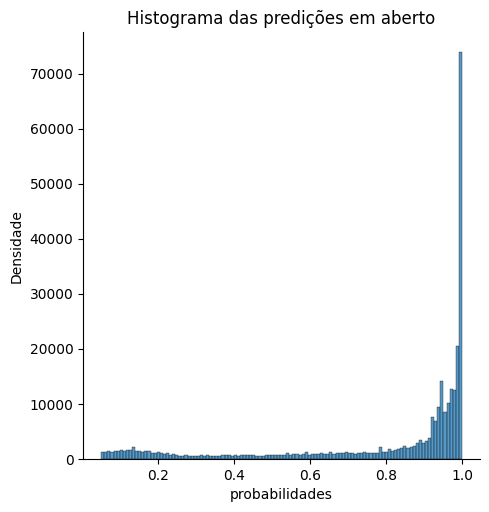

In [135]:
sns.displot(x='predicao', data=hist)

plt.title("Histograma das predições em aberto")
plt.xlabel("probabilidades")
plt.ylabel("Densidade")

plt.show()

# Definindo rating sobre a probabilidade

Definindo corte para ALTA E ALTISSIMA acima do limiar adotado

In [136]:
acima_do_limiar = df_resultado_predict.copy()
acima_do_limiar = acima_do_limiar.query('predicao >= 0.626327')

In [137]:
from sklearn.cluster import KMeans

limiar = 0.626327

acima_do_limiar['cluster'] = 0

# Ajusta o K-Means com 2 clusters para dados acima do limiar
dados_acima_limiar = acima_do_limiar[acima_do_limiar['predicao'] > limiar]['predicao'].values.reshape(-1, 1)
kmeans_acima_limiar = KMeans(n_clusters=2, random_state=42)
acima_do_limiar.loc[acima_do_limiar['predicao'] >= limiar, 'cluster'] = kmeans_acima_limiar.fit_predict(dados_acima_limiar)

Centroides acima do limiar

In [138]:
centroides_acima_limiar = acima_do_limiar.groupby('cluster')['predicao'].mean()
print("Centroides dos Clusters:")
pd.DataFrame(centroides_acima_limiar)

Centroides dos Clusters:


,predicao
cluster,
0,0.969288
1,0.763369


In [ ]:
# import pandas as pd
# from umap import UMAP

# predicao_selected = acima_do_limiar[['cluster', 'predicao']]

# umap_model = UMAP(n_components=2, random_state=22, min_dist=0.6)
# predicao_embedded = umap_model.fit_transform(predicao_selected)

# df_resultado_umap = pd.DataFrame(predicao_embedded, columns=['UMAP1', 'UMAP2'])
# df_resultado_umap = pd.concat([acima_do_limiar, df_resultado_umap], axis=1)
# df_resultado_umap

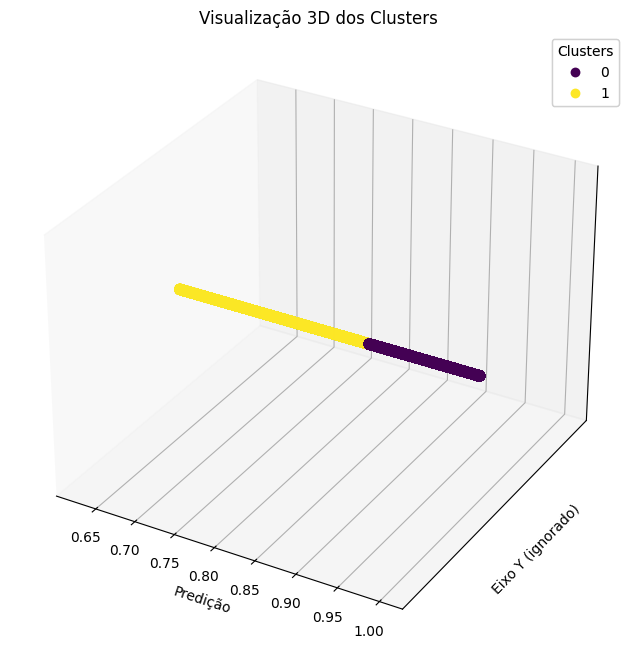

In [139]:
from mpl_toolkits.mplot3d import Axes3D

# Supondo que você tenha um DataFrame chamado 'acima_do_limiar'

# Criar o gráfico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Adicionar pontos ao gráfico 3D com base nas probabilidades e clusters
scatter = ax.scatter(xs=acima_do_limiar['predicao'], ys=np.zeros(len(acima_do_limiar)), zs=np.zeros(len(acima_do_limiar)),
                     c=acima_do_limiar['cluster'], cmap='viridis', s=50)

# Configurações adicionais do gráfico
ax.set_title('Visualização 3D dos Clusters')
ax.set_xlabel('Predição')
ax.set_ylabel('Eixo Y (ignorado)')
ax.set_zlabel('Eixo Z (ignorado)')

# Adicionar legenda
legend = ax.legend(*scatter.legend_elements(), title='Clusters')
ax.add_artist(legend)

# Remover eixos Y e Z (que estão sendo usados apenas para criar o gráfico 3D)
ax.set_yticks([])
ax.set_zticks([])

plt.show()


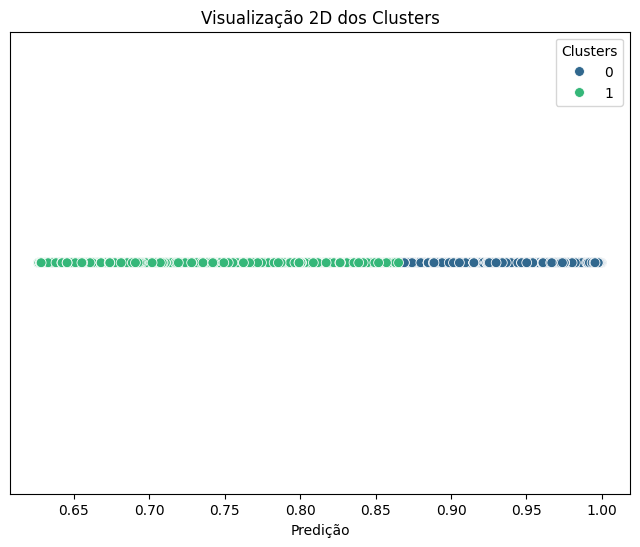

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(x='predicao', y=np.zeros(len(acima_do_limiar)), hue='cluster', data=acima_do_limiar, palette='viridis', s=50)

plt.gca().get_yaxis().set_visible(False)

plt.title('Visualização 2D dos Clusters')
plt.xlabel('Predição')
plt.legend(title='Clusters')
plt.show()


### ADICIONANDO RATING ACIMA DO LIMIAR

In [141]:
acima_do_limiar['rating'] = np.where(acima_do_limiar['cluster'] == 0, 'ALTISSIMA',
                                           np.where(acima_do_limiar['cluster'] == 1, 'ALTA', 'Outro'))
acima_do_limiar

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,bairro_encoded,pagamento,predicao,predicao_binaria,cluster,rating
7,00003a695da4777aec557718ffae83ea,4a4c53a5f2f6ac79295a294a15cb156f,6b7e2fa2f4f1a593,2024.0,31.0,132.71,1,APARTAMENTO,AFLITOS,1,...,0.0,1.0,0,0.864914,0,0,0.927739,1,0,ALTISSIMA
18,000046c85d18a6f7968646cfc1e328f2,7e5c68429978843c295a294a15cb156f,4c440987414316f6,2024.0,16.0,151.45,1,APARTAMENTO,BOA VIAGEM,1,...,0.0,1.0,0,0.862679,12,0,0.998001,1,0,ALTISSIMA
27,0000b23be5378f1b8e79cf1867e8cc19,388c1b103de0826b295a294a15cb156f,55e404b8162c12aa,2024.0,27.0,34.17,1,LOJA,AFLITOS,1,...,0.0,1.0,13,0.384999,0,0,0.992167,1,0,ALTISSIMA
39,0000b23be5378f1b8e79cf1867e8cc19,d09ff254a7b3ffbd295a294a15cb156f,f4a09ae3e8291db3,2024.0,54.0,28.00,1,SALA,BOA VISTA,1,...,0.0,1.0,17,0.384999,13,0,0.995277,1,0,ALTISSIMA
41,0000b23be5378f1b8e79cf1867e8cc19,d21e65b875141efc295a294a15cb156f,e8f779a348c050b1,2024.0,54.0,32.00,1,SALA,BOA VISTA,1,...,0.0,1.0,17,0.384999,13,0,0.995277,1,0,ALTISSIMA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266103,ffff3836dbf935321bc34267b5521a39,89585bdcccdeebd3295a294a15cb156f,0cfe1aa6943523cf,2024.0,13.0,209.97,1,APARTAMENTO,BOA VIAGEM,1,...,0.0,1.0,0,0.864188,12,0,0.946739,1,0,ALTISSIMA
2266109,ffff63826b501d84d8b209292c0ce31d,6a2b06b22e9e322d295a294a15cb156f,e5ef9115acfa782e,2024.0,41.0,213.00,1,CASA,CORDEIRO,1,...,0.0,1.0,1,0.863453,31,0,0.973839,1,0,ALTISSIMA
2266115,ffffc6563e67d8b38e79cf1867e8cc19,1235684def1b6e31295a294a15cb156f,0fb91ca37fa4509b,2024.0,32.0,159.80,1,APARTAMENTO,CORDEIRO,1,...,0.0,1.0,0,0.623564,31,0,0.994883,1,0,ALTISSIMA
2266117,ffffc6563e67d8b38e79cf1867e8cc19,3ffb562e0919eb72295a294a15cb156f,18be5a8c332a3892,2024.0,42.0,86.13,1,APARTAMENTO,IPUTINGA,1,...,0.0,1.0,0,0.623564,52,0,0.995467,1,0,ALTISSIMA


Definindo corte para BAIXISSIMA, BAIXA E MEDIA abaixo do limiar adotado

In [142]:
abaixo_do_limiar = df_resultado_predict.copy()
abaixo_do_limiar = abaixo_do_limiar.query('predicao < 0.626327')

In [143]:
from sklearn.cluster import KMeans

abaixo_do_limiar['cluster'] = 0

# Ajusta o K-Means com 3 clusters para dados abaixo do limiar usando a coluna 'predicao'
dados_abaixo_limiar = abaixo_do_limiar['predicao'].values.reshape(-1, 1)
kmeans_abaixo_limiar = KMeans(n_clusters=3, random_state=42)
abaixo_do_limiar['cluster'] = kmeans_abaixo_limiar.fit_predict(dados_abaixo_limiar)

Centroides abaixo do limiar

In [144]:
centroides_abaixo_limiar = abaixo_do_limiar.groupby('cluster')['predicao'].mean()
print("Centroides dos Clusters:")
pd.DataFrame(centroides_abaixo_limiar)

Centroides dos Clusters:


,predicao
cluster,
0,0.030486
1,0.502319
2,0.209526


In [145]:
centroides_abaixo_limiar = kmeans_abaixo_limiar.cluster_centers_
print("Centroides dos Clusters:")
for i, centroide in enumerate(centroides_abaixo_limiar):
    print(f"Cluster {i+0}: {centroide}")

Centroides dos Clusters:
Cluster 0: [0.03008087]
Cluster 1: [0.50187755]
Cluster 2: [0.20847113]


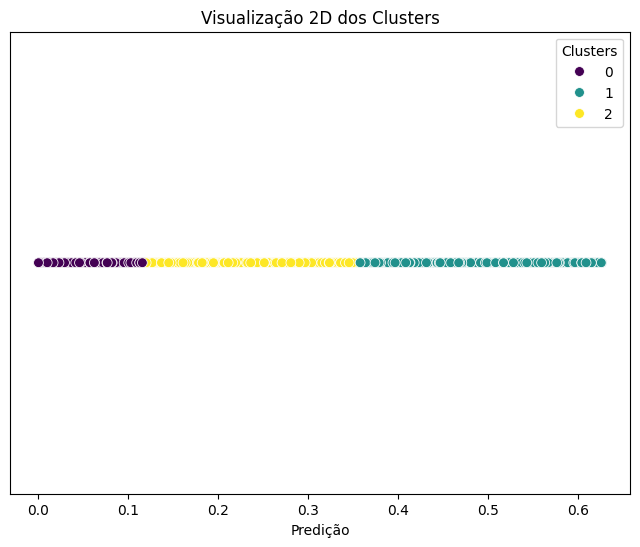

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(x='predicao', y=np.zeros(len(abaixo_do_limiar)), hue='cluster', data=abaixo_do_limiar, palette='viridis', s=50)

plt.gca().get_yaxis().set_visible(False)

# Configurações adicionais do gráfico
plt.title('Visualização 2D dos Clusters')
plt.xlabel('Predição')
plt.legend(title='Clusters')
plt.show()


### ADICIONANDO RATING ABAIXO DO LIMIAR

In [147]:
abaixo_do_limiar['rating'] = np.where(abaixo_do_limiar['cluster'] == 2, 'BAIXA',
                                      np.where(abaixo_do_limiar['cluster'] == 0, 'BAIXISSIMA',
                                               np.where(abaixo_do_limiar['cluster'] == 1, 'MEDIA', 'Outro')))
abaixo_do_limiar

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,bairro_encoded,pagamento,predicao,predicao_binaria,cluster,rating
3,0000398c485f8b42344d77602867ec09,b218328f4c7ddb4d295a294a15cb156f,1994cbd65b937ade,2024.0,56.0,110.15,1,CASA,AREIAS,1,...,0.0,1.0,1,0.166732,8,0,0.028011,0,0,BAIXISSIMA
108,000473f4656786d9d4613fe022d53698,23a36c7a396b4eee295a294a15cb156f,2e037c9c5af02537,2024.0,21.0,138.48,1,APARTAMENTO,PARNAMIRIM,1,...,0.0,1.0,0,0.185978,67,0,0.238566,0,2,BAIXA
117,000473f4656786d9d4613fe022d53698,c0d2ba6be74f8982295a294a15cb156f,cabfecc5d23c6b25,2024.0,11.0,93.79,1,APARTAMENTO,BOA VIAGEM,1,...,0.0,1.0,0,0.185978,12,0,0.261249,0,2,BAIXA
122,0004bd531fda61538e79cf1867e8cc19,376b3941d5c02a72295a294a15cb156f,2c3036b2376c2db0,2024.0,49.0,160.00,1,APARTAMENTO,GRACAS,1,...,0.0,1.0,0,0.796166,43,0,0.103990,0,0,BAIXISSIMA
143,000554c5705b8f31be91dcec7d89e48e,1ffe176230d6051b295a294a15cb156f,0fd2704b768f5ec1,2024.0,38.0,50.00,1,CASA,TEJIPIO,1,...,0.0,1.0,1,0.047225,87,0,0.036972,0,0,BAIXISSIMA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2265990,fffb82ff0c4ef8050246e2b93c1bf25c,c3c17b45117eec03295a294a15cb156f,263e230ea43a5599,2024.0,14.0,82.54,1,APARTAMENTO,TORRE,1,...,0.0,1.0,0,0.665531,88,0,0.280844,0,2,BAIXA
2266016,fffd0aa05b3e4fc40246e2b93c1bf25c,4ab74269680cf8a8295a294a15cb156f,15bdd971a7d7d41f,2024.0,16.0,534.63,1,EDIFICAÇÃO ESPECIAL,PINA,1,...,0.0,1.0,3,0.000000,71,0,0.000429,0,0,BAIXISSIMA
2266077,fffebe9391e14292344d77602867ec09,96a5d7280f3c0538295a294a15cb156f,d72c8cf6239e3a33,2024.0,1.0,118.28,1,APARTAMENTO,BOA VIAGEM,1,...,0.0,1.0,0,0.661860,12,0,0.357797,0,1,MEDIA
2266081,ffff083826a4e3f7d8b209292c0ce31d,1e30503dbd3b9ae5295a294a15cb156f,af63379fe7140354,2024.0,57.0,45.00,1,APARTAMENTO,BOA VIAGEM,1,...,0.0,1.0,0,0.643126,12,0,0.378870,0,1,MEDIA


### Unindo os dois dataframes e consolidando o rating

In [148]:
acima_do_limiar = acima_do_limiar.drop(columns=['cluster'])
abaixo_do_limiar = abaixo_do_limiar.drop(columns=['cluster'])

df_rating = pd.concat([acima_do_limiar, abaixo_do_limiar], ignore_index=True)
df_rating

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,bairro_encoded,pagamento,predicao,predicao_binaria,rating
0,00003a695da4777aec557718ffae83ea,4a4c53a5f2f6ac79295a294a15cb156f,6b7e2fa2f4f1a593,2024.0,31.0,132.71,1,APARTAMENTO,AFLITOS,1,...,0.0,0.0,1.0,0,0.864914,0,0,0.927739,1,ALTISSIMA
1,000046c85d18a6f7968646cfc1e328f2,7e5c68429978843c295a294a15cb156f,4c440987414316f6,2024.0,16.0,151.45,1,APARTAMENTO,BOA VIAGEM,1,...,0.0,0.0,1.0,0,0.862679,12,0,0.998001,1,ALTISSIMA
2,0000b23be5378f1b8e79cf1867e8cc19,388c1b103de0826b295a294a15cb156f,55e404b8162c12aa,2024.0,27.0,34.17,1,LOJA,AFLITOS,1,...,0.0,0.0,1.0,13,0.384999,0,0,0.992167,1,ALTISSIMA
3,0000b23be5378f1b8e79cf1867e8cc19,d09ff254a7b3ffbd295a294a15cb156f,f4a09ae3e8291db3,2024.0,54.0,28.00,1,SALA,BOA VISTA,1,...,0.0,0.0,1.0,17,0.384999,13,0,0.995277,1,ALTISSIMA
4,0000b23be5378f1b8e79cf1867e8cc19,d21e65b875141efc295a294a15cb156f,e8f779a348c050b1,2024.0,54.0,32.00,1,SALA,BOA VISTA,1,...,0.0,0.0,1.0,17,0.384999,13,0,0.995277,1,ALTISSIMA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344878,fffb82ff0c4ef8050246e2b93c1bf25c,c3c17b45117eec03295a294a15cb156f,263e230ea43a5599,2024.0,14.0,82.54,1,APARTAMENTO,TORRE,1,...,0.5,0.0,1.0,0,0.665531,88,0,0.280844,0,BAIXA
344879,fffd0aa05b3e4fc40246e2b93c1bf25c,4ab74269680cf8a8295a294a15cb156f,15bdd971a7d7d41f,2024.0,16.0,534.63,1,EDIFICAÇÃO ESPECIAL,PINA,1,...,0.6,0.0,1.0,3,0.000000,71,0,0.000429,0,BAIXISSIMA
344880,fffebe9391e14292344d77602867ec09,96a5d7280f3c0538295a294a15cb156f,d72c8cf6239e3a33,2024.0,1.0,118.28,1,APARTAMENTO,BOA VIAGEM,1,...,0.0,0.0,1.0,0,0.661860,12,0,0.357797,0,MEDIA
344881,ffff083826a4e3f7d8b209292c0ce31d,1e30503dbd3b9ae5295a294a15cb156f,af63379fe7140354,2024.0,57.0,45.00,1,APARTAMENTO,BOA VIAGEM,1,...,0.8,0.0,1.0,0,0.643126,12,0,0.378870,0,MEDIA


In [149]:
df_resultado_predict = df_rating.copy()

---

In [150]:
df_resultado_predict[['id_contribuinte', 'dam', 'id_imovel', 'ano',
                      'aberto','vlr_aberto', 'vlr_pago',
                      'perc_hist_pago', 'pagamento','percentual_pago', 'predicao', 'rating']]

,id_contribuinte,dam,id_imovel,ano,aberto,vlr_aberto,vlr_pago,perc_hist_pago,pagamento,percentual_pago,predicao,rating
0,00003a695da4777aec557718ffae83ea,4a4c53a5f2f6ac79295a294a15cb156f,6b7e2fa2f4f1a593,2024.0,1,1985.30,0.0,0.864914,0,0.0,0.927739,ALTISSIMA
1,000046c85d18a6f7968646cfc1e328f2,7e5c68429978843c295a294a15cb156f,4c440987414316f6,2024.0,1,4192.30,0.0,0.862679,0,0.0,0.998001,ALTISSIMA
2,0000b23be5378f1b8e79cf1867e8cc19,388c1b103de0826b295a294a15cb156f,55e404b8162c12aa,2024.0,1,799.30,0.0,0.384999,0,0.0,0.992167,ALTISSIMA
3,0000b23be5378f1b8e79cf1867e8cc19,d09ff254a7b3ffbd295a294a15cb156f,f4a09ae3e8291db3,2024.0,1,368.76,0.0,0.384999,0,0.0,0.995277,ALTISSIMA
4,0000b23be5378f1b8e79cf1867e8cc19,d21e65b875141efc295a294a15cb156f,e8f779a348c050b1,2024.0,1,365.45,0.0,0.384999,0,0.0,0.995277,ALTISSIMA
...,...,...,...,...,...,...,...,...,...,...,...,...
344878,fffb82ff0c4ef8050246e2b93c1bf25c,c3c17b45117eec03295a294a15cb156f,263e230ea43a5599,2024.0,1,1586.80,0.0,0.665531,0,0.0,0.280844,BAIXA
344879,fffd0aa05b3e4fc40246e2b93c1bf25c,4ab74269680cf8a8295a294a15cb156f,15bdd971a7d7d41f,2024.0,1,45805.50,0.0,0.000000,0,0.0,0.000429,BAIXISSIMA
344880,fffebe9391e14292344d77602867ec09,96a5d7280f3c0538295a294a15cb156f,d72c8cf6239e3a33,2024.0,1,2439.50,0.0,0.661860,0,0.0,0.357797,MEDIA
344881,ffff083826a4e3f7d8b209292c0ce31d,1e30503dbd3b9ae5295a294a15cb156f,af63379fe7140354,2024.0,1,435.96,0.0,0.643126,0,0.0,0.378870,MEDIA


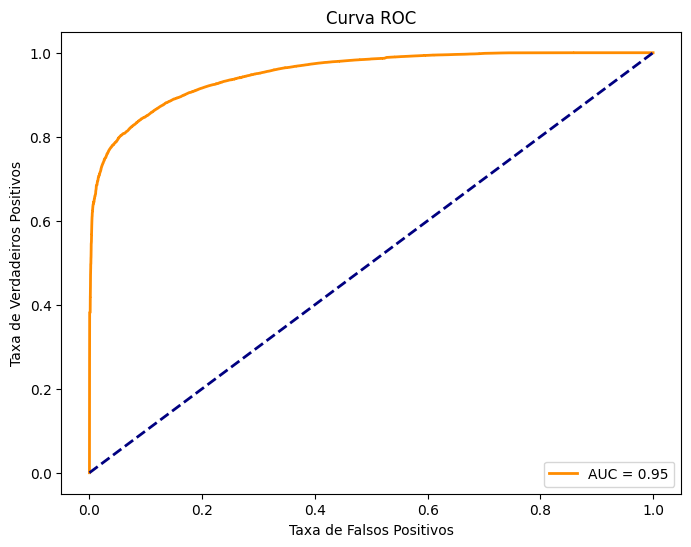

In [462]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(observado, predicao)

# Encontrar o índice do limiar mais próximo ao valor desejado
indice_limiar = (np.abs(thresholds - limiar)).argmin()
limiar_selecionado = thresholds[indice_limiar]
predicoes_binarias = (predicao >= limiar_selecionado).astype(int)

fpr, tpr, _ = roc_curve(observado, predicao)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

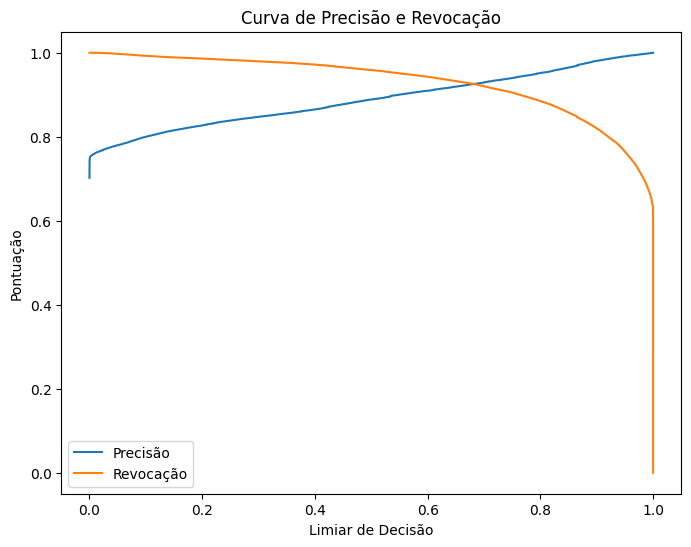

In [204]:
from sklearn.metrics import precision_recall_curve

precision, recall, limiar = precision_recall_curve(observado, predicao)

plt.figure(figsize=(8, 6))
plt.plot(limiar, precision[:-1], label='Precisão')
plt.plot(limiar, recall[:-1], label='Revocação')
plt.xlabel('Limiar de Decisão')
plt.ylabel('Pontuação')
plt.title('Curva de Precisão e Revocação')
plt.legend(loc='lower left')
plt.show()


### MATRIZ DE CONFUSÃO

In [148]:
conf_matrix = confusion_matrix(observado, predicoes_binarias)

df_conf_matrix = pd.DataFrame(conf_matrix, index=['Real Negativo', 'Real Positivo'], columns=['Predito Negativo', 'Predito Positivo'])
print("Matriz de Confusão:")
df_conf_matrix 

Matriz de Confusão:


,Predito Negativo,Predito Positivo
Real Negativo,81374,21106
Real Positivo,15110,226624


### DISTRIBUIÇÃO PERCENTUAL DA MATRIZ DE CONFUSÃO

In [149]:
conf_matrix = confusion_matrix(observado, predicoes_binarias)
total_observacoes = len(observado)
conf_matrix_percentual = conf_matrix / total_observacoes * 100

rotulos_verdadeiros = ['Real Negativo', 'Real Positivo']
rotulos_previstos = ['Predito Negativo', 'Predito Positivo']

df_conf_matrix_percentual = pd.DataFrame(conf_matrix_percentual, index=rotulos_verdadeiros, columns=rotulos_previstos)
print("Matriz de Confusão em Percentual:")
df_conf_matrix_percentual

Matriz de Confusão em Percentual:


,Predito Negativo,Predito Positivo
Real Negativo,23.640526,6.131651
Real Positivo,4.389711,65.838112


### Corte em que o nosso f1-score é o melhor = 0.926009

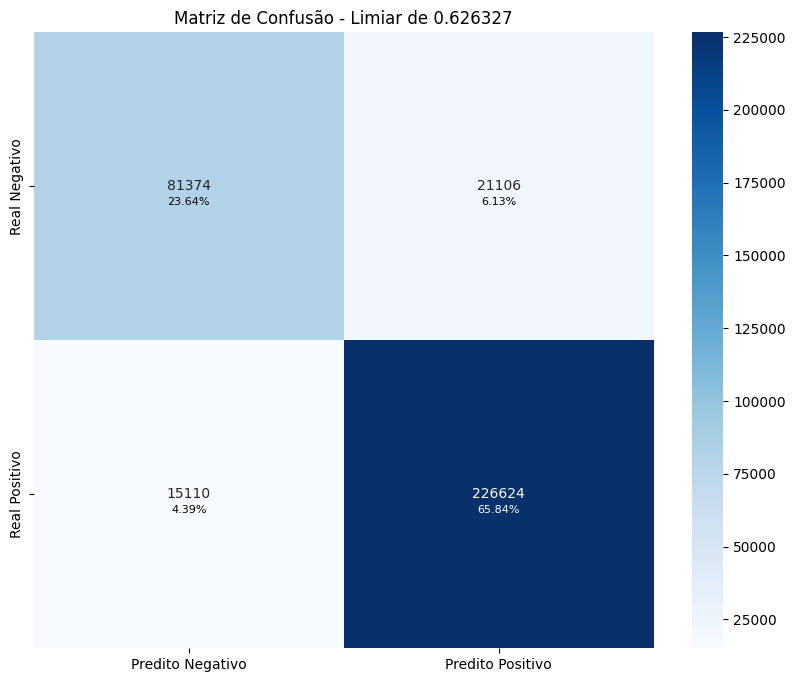

In [150]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f"Matriz de Confusão - Limiar de {limiar}")

for i in range(df_conf_matrix.shape[0]):
    for j in range(df_conf_matrix.shape[1]):
        text = f'{df_conf_matrix_percentual.iloc[i, j]:.2f}%'
        color = 'black' if df_conf_matrix.iloc[i, j] < df_conf_matrix.values.max() / 2 else 'white'
        plt.text(j + 0.5, i + 0.5 + 0.05, text, ha='center', va='center', color=color, fontsize=8)
plt.show()

### Corte em que aumentamos os erros onde a pessoa paga e prevemos que ela não pagaria

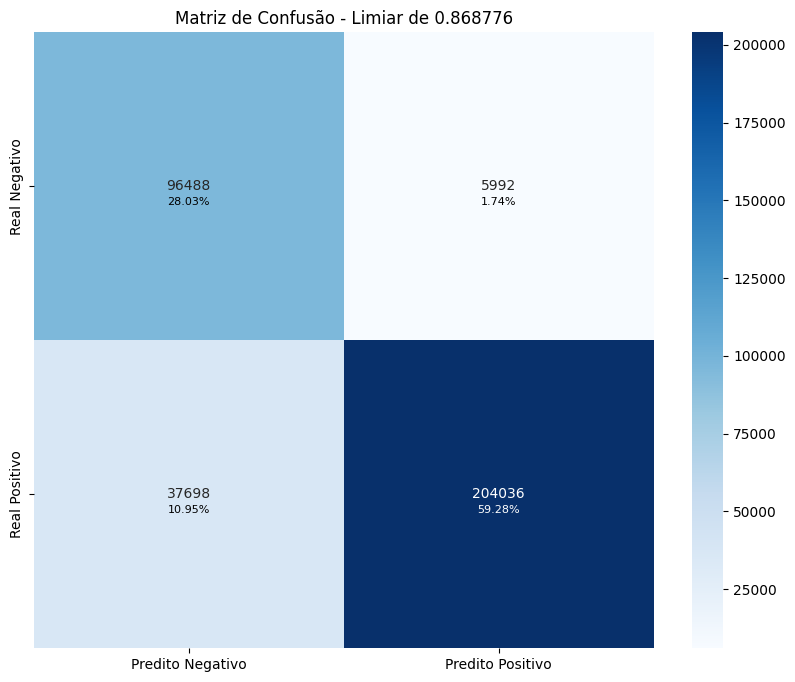

In [253]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f"Matriz de Confusão - Limiar de {limiar}")

for i in range(df_conf_matrix.shape[0]):
    for j in range(df_conf_matrix.shape[1]):
        text = f'{df_conf_matrix_percentual.iloc[i, j]:.2f}%'
        color = 'black' if df_conf_matrix.iloc[i, j] < df_conf_matrix.values.max() / 2 else 'white'
        plt.text(j + 0.5, i + 0.5 + 0.05, text, ha='center', va='center', color=color, fontsize=8)
plt.show()

### Corte em que o limiar ou thresholds é padrão sendo 50%

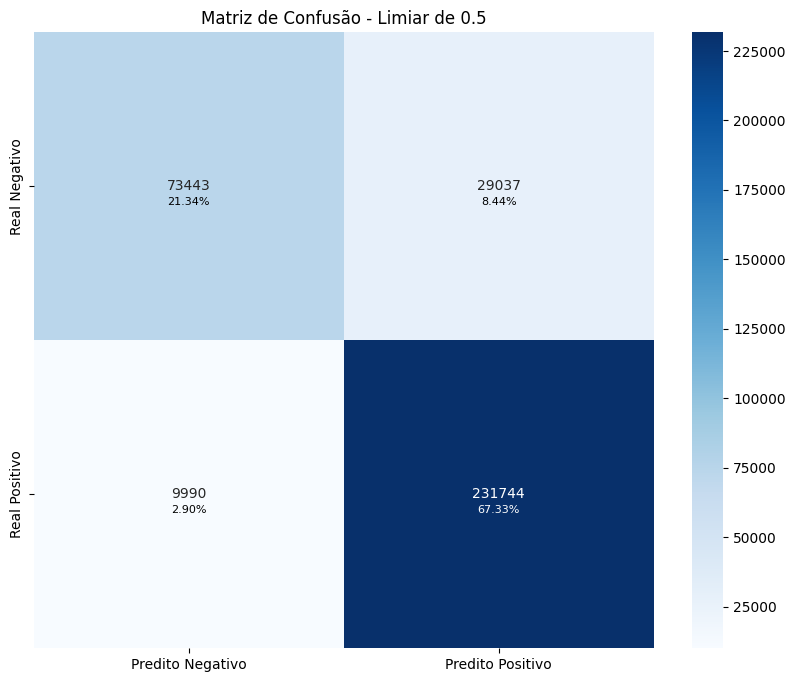

In [282]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f"Matriz de Confusão - Limiar de {limiar}")

for i in range(df_conf_matrix.shape[0]):
    for j in range(df_conf_matrix.shape[1]):
        text = f'{df_conf_matrix_percentual.iloc[i, j]:.2f}%'
        color = 'black' if df_conf_matrix.iloc[i, j] < df_conf_matrix.values.max() / 2 else 'white'
        plt.text(j + 0.5, i + 0.5 + 0.05, text, ha='center', va='center', color=color, fontsize=8)
plt.show()

In [151]:
acuracia = accuracy_score(observado, predicoes_binarias)
roc_auc = roc_auc_score(observado, predicao)
precisao = precision_score(observado, predicoes_binarias)
revocacao = recall_score(observado, predicoes_binarias)
f1 = f1_score(observado, predicoes_binarias)
print(f"Accuracia: {acuracia}")
print(f"ROC AUC: {roc_auc}")
print(f"Precisão: {precisao}")
print(f"Revocação (Sensibilidade): {revocacao}")
print(f"F1 Score: {f1}")

Accuracia: 0.8947863828897139
ROC AUC: 0.9619238735547457
Precisão: 0.9148024058450732
Revocação (Sensibilidade): 0.9374932777350311
F1 Score: 0.9260088586698919


# RESÍDUOS

In [151]:
df_resultado_predict.columns

Index(['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel',
       'area_construida', 'natureza_imovel', 'tipo_propriedade', 'bairro',
       'aberto', 'num_imoveis', 'vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'pgt_cota_unica', 'hist_cota_unica', 'hist_pagamento', 'hist_lancado',
       'reco_debito', 'reco_credito', 'reco_divida_ativa',
       'percentual_pago_cota', 'percentual_reco_debito',
       'percentual_reco_divida_ativa', 'percentual_pago', 'tipo_contribuinte',
       'tipo_propriedade_encoded', 'perc_hist_pago', 'bairro_encoded',
       'pagamento', 'predicao', 'predicao_binaria', 'rating'],
      dtype='object')

In [152]:
prova = df_resultado_predict.query('id_contribuinte == "7b652334d0105f489daa7b7dbb545c1c"')
prova = prova[['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel','natureza_imovel', 'tipo_propriedade', 'bairro',
       'vlr_aberto', 'vlr_pago', 'vlr_lancado','hist_pagamento', 'hist_lancado', 'area_construida',
       'reco_debito', 'reco_credito', 'reco_divida_ativa','percentual_reco_divida_ativa','tipo_contribuinte', 'predicao']]
prova

,id_contribuinte,dam,id_imovel,ano,idade_imovel,natureza_imovel,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,hist_pagamento,hist_lancado,area_construida,reco_debito,reco_credito,reco_divida_ativa,percentual_reco_divida_ativa,tipo_contribuinte,predicao
117624,7b652334d0105f489daa7b7dbb545c1c,04277e8dfbb8e817295a294a15cb156f,65cef61dc2a8520c,2024.0,43.0,1,CASA,AGUA FRIA,0.0,1159.9,1159.9,10731.52,487085.88,108.60,0.0,11.0,0.0,1.0,1.0,0.999903
117625,7b652334d0105f489daa7b7dbb545c1c,0816556e0c3fbbab295a294a15cb156f,97719ac1e50267b9,2024.0,38.0,1,APARTAMENTO,AGUA FRIA,0.0,757.1,757.1,10731.52,487085.88,87.74,0.0,11.0,0.0,1.0,1.0,0.999861
117626,7b652334d0105f489daa7b7dbb545c1c,09a7973dae9bfd2b295a294a15cb156f,af4fed91a8ef1b4f,2024.0,37.0,1,APARTAMENTO,AGUA FRIA,0.0,762.0,762.0,10731.52,487085.88,89.13,0.0,11.0,0.0,1.0,1.0,0.999861
117627,7b652334d0105f489daa7b7dbb545c1c,09c31539cd6260de295a294a15cb156f,0542225bf158bf95,2024.0,78.0,1,CASA,AGUA FRIA,945.9,0.0,945.9,10731.52,487085.88,50.63,0.0,11.0,0.0,1.0,1.0,0.999896
117628,7b652334d0105f489daa7b7dbb545c1c,0bab10aebf68cb24295a294a15cb156f,891620b42a6e1074,2024.0,38.0,1,APARTAMENTO,AGUA FRIA,0.0,757.1,757.1,10731.52,487085.88,87.74,0.0,11.0,0.0,1.0,1.0,0.999861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117711,7b652334d0105f489daa7b7dbb545c1c,f0fbf340a09c2079295a294a15cb156f,1916ddf34184b558,2024.0,37.0,1,APARTAMENTO,AGUA FRIA,0.0,757.1,757.1,10731.52,487085.88,87.74,0.0,11.0,0.0,1.0,1.0,0.999861
117712,7b652334d0105f489daa7b7dbb545c1c,f1cb2d7d5378160e295a294a15cb156f,a45ac788bc6a998a,2024.0,37.0,1,APARTAMENTO,AGUA FRIA,0.0,769.7,769.7,10731.52,487085.88,91.29,0.0,11.0,0.0,1.0,1.0,0.999861
117713,7b652334d0105f489daa7b7dbb545c1c,f912f9a4ba3d0651295a294a15cb156f,e8cb68bb7a6a98c9,2024.0,36.0,1,LOJA,AGUA FRIA,1104.8,0.0,1104.8,10731.52,487085.88,52.04,0.0,11.0,0.0,1.0,1.0,0.999921
117714,7b652334d0105f489daa7b7dbb545c1c,fb96cd8653004731295a294a15cb156f,521912342bb2bc44,2024.0,38.0,1,APARTAMENTO,AGUA FRIA,0.0,762.0,762.0,10731.52,487085.88,89.13,0.0,11.0,0.0,1.0,1.0,0.999861


In [153]:
resultado = df_resultado_predict.copy()
aberto = resultado.query('vlr_pago != vlr_lancado')
fechado = resultado.query('vlr_pago == vlr_lancado')

In [154]:
def categorizar_porte(row):
    tipo_propriedade = row['tipo_propriedade']
    area_construida = row['area_construida']
 
    if tipo_propriedade == 'APARTAMENTO':
        if area_construida <= 60:
            return 'PEQUENO'
        elif 60 < area_construida <= 100:
            return 'MEDIO'
        else:
            return 'GRANDE'
 
    elif tipo_propriedade == 'CASA':
        if area_construida <= 100:
            return 'PEQUENO'
        elif 100 < area_construida <= 200:
            return 'MEDIO'
        else:
            return 'GRANDE'
 
    elif tipo_propriedade == 'LOJA':
        if area_construida <= 50:
            return 'PEQUENO'
        elif 50 < area_construida <= 200:
            return 'MEDIO'
        else:
            return 'GRANDE'
 
    elif tipo_propriedade == 'GARAGEM COMERCIAL':
        if area_construida <= 500:
            return 'PEQUENO'
        elif 500 < area_construida <= 2000:
            return 'MEDIO'
        else:
            return 'GRANDE'
 
    elif tipo_propriedade == 'GALPAO':
        if 200 < area_construida <= 500:
            return 'PEQUENO'
        elif 500 < area_construida <= 2000:
            return 'MEDIO'
        else:
            return 'GRANDE'
 
    elif tipo_propriedade == 'SALA':
        if 20 <= area_construida <= 50:
            return 'PEQUENO'
        elif 50 < area_construida <= 150:
            return 'MEDIO'
        else:
            return 'GRANDE'
 
    else:
        return 'INDEFINIDO'
aberto['tamanho_imovel'] = aberto.apply(categorizar_porte, axis=1)
aberto

C:\Users\Acer\AppData\Local\Temp\ipykernel_12032\2195418008.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aberto['tamanho_imovel'] = aberto.apply(categorizar_porte, axis=1)


,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,bairro_encoded,pagamento,predicao,predicao_binaria,rating,tamanho_imovel
0,00003a695da4777aec557718ffae83ea,4a4c53a5f2f6ac79295a294a15cb156f,6b7e2fa2f4f1a593,2024.0,31.0,132.71,1,APARTAMENTO,AFLITOS,1,...,0.0,1.0,0,0.864914,0,0,0.927739,1,ALTISSIMA,GRANDE
1,000046c85d18a6f7968646cfc1e328f2,7e5c68429978843c295a294a15cb156f,4c440987414316f6,2024.0,16.0,151.45,1,APARTAMENTO,BOA VIAGEM,1,...,0.0,1.0,0,0.862679,12,0,0.998001,1,ALTISSIMA,GRANDE
2,0000b23be5378f1b8e79cf1867e8cc19,388c1b103de0826b295a294a15cb156f,55e404b8162c12aa,2024.0,27.0,34.17,1,LOJA,AFLITOS,1,...,0.0,1.0,13,0.384999,0,0,0.992167,1,ALTISSIMA,PEQUENO
3,0000b23be5378f1b8e79cf1867e8cc19,d09ff254a7b3ffbd295a294a15cb156f,f4a09ae3e8291db3,2024.0,54.0,28.00,1,SALA,BOA VISTA,1,...,0.0,1.0,17,0.384999,13,0,0.995277,1,ALTISSIMA,PEQUENO
4,0000b23be5378f1b8e79cf1867e8cc19,d21e65b875141efc295a294a15cb156f,e8f779a348c050b1,2024.0,54.0,32.00,1,SALA,BOA VISTA,1,...,0.0,1.0,17,0.384999,13,0,0.995277,1,ALTISSIMA,PEQUENO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344878,fffb82ff0c4ef8050246e2b93c1bf25c,c3c17b45117eec03295a294a15cb156f,263e230ea43a5599,2024.0,14.0,82.54,1,APARTAMENTO,TORRE,1,...,0.0,1.0,0,0.665531,88,0,0.280844,0,BAIXA,MEDIO
344879,fffd0aa05b3e4fc40246e2b93c1bf25c,4ab74269680cf8a8295a294a15cb156f,15bdd971a7d7d41f,2024.0,16.0,534.63,1,EDIFICAÇÃO ESPECIAL,PINA,1,...,0.0,1.0,3,0.000000,71,0,0.000429,0,BAIXISSIMA,INDEFINIDO
344880,fffebe9391e14292344d77602867ec09,96a5d7280f3c0538295a294a15cb156f,d72c8cf6239e3a33,2024.0,1.0,118.28,1,APARTAMENTO,BOA VIAGEM,1,...,0.0,1.0,0,0.661860,12,0,0.357797,0,MEDIA,GRANDE
344881,ffff083826a4e3f7d8b209292c0ce31d,1e30503dbd3b9ae5295a294a15cb156f,af63379fe7140354,2024.0,57.0,45.00,1,APARTAMENTO,BOA VIAGEM,1,...,0.0,1.0,0,0.643126,12,0,0.378870,0,MEDIA,PEQUENO


In [155]:
aberto.select_dtypes(include='object').describe()

,id_contribuinte,dam,id_imovel,tipo_propriedade,bairro,rating,tamanho_imovel
count,329051,329051,329051,329051,329051,329051,329051
unique,208806,329051,329050,20,95,5,4
top,878ed023fa473bede000edc2a2086273,4a4c53a5f2f6ac79295a294a15cb156f,cbe9e6fb3c67aba5,APARTAMENTO,BOA VIAGEM,ALTISSIMA,GRANDE
freq,1527,1,2,183762,64147,195393,121887


In [156]:
limiar62 = fechado.groupby(['rating']).agg({
    'id_imovel': 'nunique',
    'dam': 'nunique',
    'vlr_pago': 'sum'
}).reset_index()

order = ['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA']
limiar62['rating'] = pd.Categorical(limiar62['rating'], categories=order, ordered=True)

limiar62 = limiar62.sort_values(by='rating')
limiar62.reset_index(drop=True, inplace=True)

limiar62['vlr_pago'] = limiar62['vlr_pago'].apply(formatar_moeda)
limiar62

,rating,id_imovel,dam,vlr_pago
0,BAIXISSIMA,139,139,"R$ 258.511,99"
1,BAIXA,318,318,"R$ 601.157,15"
2,MEDIA,357,357,"R$ 794.464,41"
3,ALTA,846,846,"R$ 2.035.876,08"
4,ALTISSIMA,14172,14172,"R$ 36.766.096,41"


In [202]:
residuos_pred = fechado.query('pagamento != predicao_binaria')
# residuos_pred = fechado.query('pagamento == predicao_binaria')
residuos_pred

,id_contribuinte,dam,id_imovel,ano,aberto,vlr_aberto,vlr_pago,vlr_lancado,pagamento,perc_hist_pago,pagamento,percentual_pago,predicao,predicao_binaria,rating
247731,00014b72ca2a255bd4613fe022d53698,20ebf87a9ba4e38090ecf5aaf6be6eb7,ab1890872c8b1262,2023.0,0,0.0,1657.00,1657.00,1,0.988763,1,1.0,0.428725,0,MEDIA
247733,000473f4656786d9d4613fe022d53698,79fa28d80ba2d56290ecf5aaf6be6eb7,cabfecc5d23c6b25,2023.0,0,0.0,349.97,349.97,1,0.165668,1,1.0,0.334544,0,BAIXA
247735,0004bd531fda61538e79cf1867e8cc19,b5222231f94b1ad990ecf5aaf6be6eb7,2c3036b2376c2db0,2023.0,0,0.0,1981.08,1981.08,1,0.916442,1,1.0,0.095930,0,BAIXISSIMA
247740,000777f57c8049368dd06342399984d9,7c39c6ca0cd480bc90ecf5aaf6be6eb7,bc3471350be601d8,2023.0,0,0.0,657.20,657.20,1,0.997733,1,1.0,0.020680,0,BAIXISSIMA
247747,000a8913b4e31d3d8e79cf1867e8cc19,f365a540a09f16e490ecf5aaf6be6eb7,71711296a8eaa8bb,2023.0,0,0.0,264.32,264.32,1,0.595292,1,1.0,0.204525,0,BAIXA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344164,ffd7d05f74336f5375234379af146d63,8599eae9c702e47490ecf5aaf6be6eb7,7f7bae73f6a06b5e,2023.0,0,0.0,22674.00,22674.00,1,0.649372,1,1.0,0.546300,0,MEDIA
344181,ffe7c931fa501929adaf8563a746964a,4cd098df9442e6ed90ecf5aaf6be6eb7,a8cfcc158d3239da,2023.0,0,0.0,958.84,958.84,1,0.408619,1,1.0,0.280253,0,BAIXA
344182,ffe84a305c155a3dd8b209292c0ce31d,4878546606b0108490ecf5aaf6be6eb7,6955eea0e9ea4c11,2023.0,0,0.0,541.14,541.14,1,0.419016,1,1.0,0.557600,0,MEDIA
344199,fff5cca302e832fdb611c7a529816b3d,bc3d56055a950f5390ecf5aaf6be6eb7,001c7e409ebd34be,2023.0,0,0.0,2287.91,2287.91,1,0.798473,1,1.0,0.363955,0,BAIXA


In [157]:
aberto.columns

Index(['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel',
       'area_construida', 'natureza_imovel', 'tipo_propriedade', 'bairro',
       'aberto', 'num_imoveis', 'vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'pgt_cota_unica', 'hist_cota_unica', 'hist_pagamento', 'hist_lancado',
       'reco_debito', 'reco_credito', 'reco_divida_ativa',
       'percentual_pago_cota', 'percentual_reco_debito',
       'percentual_reco_divida_ativa', 'percentual_pago', 'tipo_contribuinte',
       'tipo_propriedade_encoded', 'perc_hist_pago', 'bairro_encoded',
       'pagamento', 'predicao', 'predicao_binaria', 'rating',
       'tamanho_imovel'],
      dtype='object')

In [158]:
limiar62_estoque = aberto.groupby(['rating']).agg({
    'id_imovel': 'nunique',
    'dam': 'nunique',
    'vlr_aberto': 'sum',
    'vlr_lancado': 'sum',
    'id_contribuinte': 'nunique'
}).reset_index()

order = ['BAIXISSIMA', 'BAIXA', 'MEDIA', 'ALTA', 'ALTISSIMA']
limiar62_estoque['rating'] = pd.Categorical(limiar62_estoque['rating'], categories=order, ordered=True)

limiar62_estoque = limiar62_estoque.sort_values(by='rating')
limiar62_estoque.reset_index(drop=True, inplace=True)

limiar62_estoque['vlr_aberto'] = limiar62_estoque['vlr_aberto'].apply(formatar_moeda)
limiar62_estoque['vlr_lancado'] = limiar62_estoque['vlr_lancado'].apply(formatar_moeda)
limiar62_estoque

,rating,id_imovel,dam,vlr_aberto,vlr_lancado,id_contribuinte
0,BAIXISSIMA,45638,45638,"R$ 101.301.022,36","R$ 101.343.647,68",40603
1,BAIXA,27150,27150,"R$ 67.558.424,31","R$ 67.667.361,50",23540
2,MEDIA,22993,22993,"R$ 66.059.621,46","R$ 66.153.386,33",13589
3,ALTA,37877,37877,"R$ 118.449.136,56","R$ 118.601.173,98",16282
4,ALTISSIMA,195392,195393,"R$ 716.899.675,96","R$ 717.732.561,16",120379


In [476]:
alti = aberto.query('rating == "ALTISSIMA"').sort_values(by='predicao', ascending=False)
# alti = alti.query('predicao > 0.90')
alti = alti[['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel','natureza_imovel', 'tipo_propriedade', 'bairro',
       'vlr_aberto', 'vlr_pago', 'vlr_lancado','hist_pagamento', 'hist_lancado', 'area_construida',
       'reco_debito', 'reco_credito', 'reco_divida_ativa','percentual_reco_divida_ativa','tipo_contribuinte', 'predicao']]

In [477]:
caminho = r'C:\Users\Acer\Projetos\Recife\dados\resultado_modelo_2023\altissima.xlsx'
alti.to_excel(caminho, index=False)